In [54]:
import numpy as np
import pandas as pd

# Read the predictions per position
wt_fold_preds_Evo = pd.read_csv("../Results/wt_evofit.csv")
mut_fold_preds_Evo = pd.read_csv("../Results/mutant_evofit.csv")

# Read the matched dataset
dfPKD2 = pd.read_csv("PKD2.csv")
dfGLMN = pd.read_csv("GLMN.csv")
dfDPOG1 = pd.read_csv("DPOG1.csv")
dfFGFR1 = pd.read_csv("FGFR1.csv")

allseqs = pd.read_csv("../Data/final_dataset_3820_indels_curated_matched.csv")

In [55]:
PKD2seq = allseqs[allseqs['ids'].isin(dfPKD2['Id_matching'])]
GLMNseq = allseqs[allseqs['ids'].isin(dfGLMN['Id_matching'])]
DPOG1seq = allseqs[allseqs['ids'].isin(dfDPOG1['Id_matching'])]
FGFR1seq = allseqs[allseqs['ids'].isin(dfFGFR1['Id_matching'])]

PKD2scores_Evo_wt = wt_fold_preds_Evo[wt_fold_preds_Evo['id'].isin(dfPKD2['Id_matching'])]
PKD2scores_Evo_mut = mut_fold_preds_Evo[mut_fold_preds_Evo['id'].isin(dfPKD2['Id_matching'])]
GLMNscores_Evo_wt = wt_fold_preds_Evo[wt_fold_preds_Evo['id'].isin(dfGLMN['Id_matching'])]
GLMNscores_Evo_mut = mut_fold_preds_Evo[mut_fold_preds_Evo['id'].isin(dfGLMN['Id_matching'])]
DPOG1scores_Evo_wt = wt_fold_preds_Evo[wt_fold_preds_Evo['id'].isin(dfDPOG1['Id_matching'])]
DPOG1scores_Evo_mut = mut_fold_preds_Evo[mut_fold_preds_Evo['id'].isin(dfDPOG1['Id_matching'])]
FGFR1scores_Evo_wt = wt_fold_preds_Evo[wt_fold_preds_Evo['id'].isin(dfFGFR1['Id_matching'])]
FGFR1scores_Evo_mut = mut_fold_preds_Evo[mut_fold_preds_Evo['id'].isin(dfFGFR1['Id_matching'])]


In [56]:
#PKD2seq
#GLMNseq
#DPOG1seq
#FGFR1seq

In [57]:
from Bio.Align import PairwiseAligner
import pandas as pd
aligner = PairwiseAligner()
aligner.mode = 'global'

# Define the sequences to align
PKD2wt = PKD2seq.loc[PKD2seq['ids'] == 857, 'wt_seqs'].values[0]
PKD2mut_id857 = PKD2seq.loc[PKD2seq['ids'] == 857, 'mut_seqs'].values[0]
PKD2mut_id858 = PKD2seq.loc[PKD2seq['ids'] == 858, 'mut_seqs'].values[0]
PKD2mut_id859 = PKD2seq.loc[PKD2seq['ids'] == 859, 'mut_seqs'].values[0]
PKD2mut_id860 = PKD2seq.loc[PKD2seq['ids'] == 860, 'mut_seqs'].values[0]
PKD2mut_id861 = PKD2seq.loc[PKD2seq['ids'] == 861, 'mut_seqs'].values[0]

GLMNwt = GLMNseq.loc[GLMNseq['ids'] == 128, 'wt_seqs'].values[0]
GLMNmut_id128 = GLMNseq.loc[GLMNseq['ids'] == 128, 'mut_seqs'].values[0]
GLMNmut_id129 = GLMNseq.loc[GLMNseq['ids'] == 129, 'mut_seqs'].values[0]
GLMNmut_id130 = GLMNseq.loc[GLMNseq['ids'] == 130, 'mut_seqs'].values[0]

DPOG1wt = DPOG1seq.loc[DPOG1seq['ids'] == 2568, 'wt_seqs'].values[0]
DPOG1mut_id2568 = DPOG1seq.loc[DPOG1seq['ids'] == 2568, 'mut_seqs'].values[0]
DPOG1mut_id2569 = DPOG1seq.loc[DPOG1seq['ids'] == 2569, 'mut_seqs'].values[0]
DPOG1mut_id2570 = DPOG1seq.loc[DPOG1seq['ids'] == 2570, 'mut_seqs'].values[0]
DPOG1mut_id2571 = DPOG1seq.loc[DPOG1seq['ids'] == 2571, 'mut_seqs'].values[0]
DPOG1mut_id2572 = DPOG1seq.loc[DPOG1seq['ids'] == 2572, 'mut_seqs'].values[0]
DPOG1mut_id2573 = DPOG1seq.loc[DPOG1seq['ids'] == 2573, 'mut_seqs'].values[0]
DPOG1mut_id2574 = DPOG1seq.loc[DPOG1seq['ids'] == 2574, 'mut_seqs'].values[0]
DPOG1mut_id2575 = DPOG1seq.loc[DPOG1seq['ids'] == 2575, 'mut_seqs'].values[0]
DPOG1mut_id2576 = DPOG1seq.loc[DPOG1seq['ids'] == 2576, 'mut_seqs'].values[0]
DPOG1mut_id2577 = DPOG1seq.loc[DPOG1seq['ids'] == 2577, 'mut_seqs'].values[0]
DPOG1mut_id2578 = DPOG1seq.loc[DPOG1seq['ids'] == 2578, 'mut_seqs'].values[0]
DPOG1mut_id2579 = DPOG1seq.loc[DPOG1seq['ids'] == 2579, 'mut_seqs'].values[0]
DPOG1mut_id2580 = DPOG1seq.loc[DPOG1seq['ids'] == 2580, 'mut_seqs'].values[0]
DPOG1mut_id2581 = DPOG1seq.loc[DPOG1seq['ids'] == 2581, 'mut_seqs'].values[0]
DPOG1mut_id2582 = DPOG1seq.loc[DPOG1seq['ids'] == 2582, 'mut_seqs'].values[0]
DPOG1mut_id2583 = DPOG1seq.loc[DPOG1seq['ids'] == 2583, 'mut_seqs'].values[0]
DPOG1mut_id2584 = DPOG1seq.loc[DPOG1seq['ids'] == 2584, 'mut_seqs'].values[0]
DPOG1mut_id2585 = DPOG1seq.loc[DPOG1seq['ids'] == 2585, 'mut_seqs'].values[0]
DPOG1mut_id2586 = DPOG1seq.loc[DPOG1seq['ids'] == 2586, 'mut_seqs'].values[0]
DPOG1mut_id2587 = DPOG1seq.loc[DPOG1seq['ids'] == 2587, 'mut_seqs'].values[0]
DPOG1mut_id2588 = DPOG1seq.loc[DPOG1seq['ids'] == 2588, 'mut_seqs'].values[0]

FGFR1wt = FGFR1seq.loc[FGFR1seq['ids'] == 1479, 'wt_seqs'].values[0]
FGFR1mut_id1479 = FGFR1seq.loc[FGFR1seq['ids'] == 1479, 'mut_seqs'].values[0]
FGFR1mut_id1480 = FGFR1seq.loc[FGFR1seq['ids'] == 1480, 'mut_seqs'].values[0]
FGFR1mut_id1481 = FGFR1seq.loc[FGFR1seq['ids'] == 1481, 'mut_seqs'].values[0]
FGFR1mut_id1482 = FGFR1seq.loc[FGFR1seq['ids'] == 1482, 'mut_seqs'].values[0]

# Align the sequences
PKD2_id857 = aligner.align(PKD2wt, PKD2mut_id857)
PKD2_id858 = aligner.align(PKD2wt, PKD2mut_id858)
PKD2_id859 = aligner.align(PKD2wt, PKD2mut_id859)
PKD2_id860 = aligner.align(PKD2wt, PKD2mut_id860)
PKD2_id861 = aligner.align(PKD2wt, PKD2mut_id861)

GLMN_id128 = aligner.align(GLMNwt, GLMNmut_id128)
GLMN_id129 = aligner.align(GLMNwt, GLMNmut_id129)
GLMN_id130 = aligner.align(GLMNwt, GLMNmut_id130)

DPOG1_id2568 = aligner.align(DPOG1wt, DPOG1mut_id2568)
DPOG1_id2569 = aligner.align(DPOG1wt, DPOG1mut_id2569)
DPOG1_id2570 = aligner.align(DPOG1wt, DPOG1mut_id2570)
DPOG1_id2571 = aligner.align(DPOG1wt, DPOG1mut_id2571)
DPOG1_id2572 = aligner.align(DPOG1wt, DPOG1mut_id2572)
DPOG1_id2573 = aligner.align(DPOG1wt, DPOG1mut_id2573)
DPOG1_id2574 = aligner.align(DPOG1wt, DPOG1mut_id2574)
DPOG1_id2575 = aligner.align(DPOG1wt, DPOG1mut_id2575)
DPOG1_id2576 = aligner.align(DPOG1wt, DPOG1mut_id2576)
DPOG1_id2577 = aligner.align(DPOG1wt, DPOG1mut_id2577)
DPOG1_id2578 = aligner.align(DPOG1wt, DPOG1mut_id2578)
DPOG1_id2579 = aligner.align(DPOG1wt, DPOG1mut_id2579)
DPOG1_id2580 = aligner.align(DPOG1wt, DPOG1mut_id2580)
DPOG1_id2581 = aligner.align(DPOG1wt, DPOG1mut_id2581)
DPOG1_id2582 = aligner.align(DPOG1wt, DPOG1mut_id2582)
DPOG1_id2583 = aligner.align(DPOG1wt, DPOG1mut_id2583)
DPOG1_id2584 = aligner.align(DPOG1wt, DPOG1mut_id2584)
DPOG1_id2585 = aligner.align(DPOG1wt, DPOG1mut_id2585)
DPOG1_id2586 = aligner.align(DPOG1wt, DPOG1mut_id2586)
DPOG1_id2587 = aligner.align(DPOG1wt, DPOG1mut_id2587)
DPOG1_id2588 = aligner.align(DPOG1wt, DPOG1mut_id2588)

FGFR1_id1479 = aligner.align(FGFR1wt, FGFR1mut_id1479)
FGFR1_id1480 = aligner.align(FGFR1wt, FGFR1mut_id1480)
FGFR1_id1481 = aligner.align(FGFR1wt, FGFR1mut_id1481)
FGFR1_id1482 = aligner.align(FGFR1wt, FGFR1mut_id1482)

# Get the first alignment (best alignment)
PKD2_id857_alignment = PKD2_id857[0]
PKD2_id858_alignment = PKD2_id858[0]
PKD2_id859_alignment = PKD2_id859[0]
PKD2_id860_alignment = PKD2_id860[0]
PKD2_id861_alignment = PKD2_id861[0]

GLMN_id128_alignment = GLMN_id128[0]
GLMN_id129_alignment = GLMN_id129[0]
GLMN_id130_alignment = GLMN_id130[0]

DPOG1_id2568_alignment = DPOG1_id2568[0]
DPOG1_id2569_alignment = DPOG1_id2569[0]
DPOG1_id2570_alignment = DPOG1_id2570[0]
DPOG1_id2571_alignment = DPOG1_id2571[0]
DPOG1_id2572_alignment = DPOG1_id2572[0]
DPOG1_id2573_alignment = DPOG1_id2573[0]
DPOG1_id2574_alignment = DPOG1_id2574[0]
DPOG1_id2575_alignment = DPOG1_id2575[0]
DPOG1_id2576_alignment = DPOG1_id2576[0]
DPOG1_id2577_alignment = DPOG1_id2577[0]
DPOG1_id2578_alignment = DPOG1_id2578[0]
DPOG1_id2579_alignment = DPOG1_id2579[0]
DPOG1_id2580_alignment = DPOG1_id2580[0]
DPOG1_id2581_alignment = DPOG1_id2581[0]
DPOG1_id2582_alignment = DPOG1_id2582[0]
DPOG1_id2583_alignment = DPOG1_id2583[0]
DPOG1_id2584_alignment = DPOG1_id2584[0]
DPOG1_id2585_alignment = DPOG1_id2585[0]
DPOG1_id2586_alignment = DPOG1_id2586[0]
DPOG1_id2587_alignment = DPOG1_id2587[0]
DPOG1_id2588_alignment = DPOG1_id2588[0]

FGFR1_id1479_alignment = FGFR1_id1479[0]
FGFR1_id1480_alignment = FGFR1_id1480[0]
FGFR1_id1481_alignment = FGFR1_id1481[0]
FGFR1_id1482_alignment = FGFR1_id1482[0]

# Extract aligned sequences
aligned_PKD2_857wt = PKD2_id857_alignment.aligned[0]
aligned_PKD2_857mut = PKD2_id857_alignment.aligned[1]
aligned_PKD2_858wt = PKD2_id858_alignment.aligned[0]
aligned_PKD2_858mut = PKD2_id858_alignment.aligned[1]
aligned_PKD2_859wt = PKD2_id859_alignment.aligned[0]
aligned_PKD2_859mut = PKD2_id859_alignment.aligned[1]
aligned_PKD2_860wt = PKD2_id860_alignment.aligned[0]
aligned_PKD2_860mut = PKD2_id860_alignment.aligned[1]
aligned_PKD2_861wt = PKD2_id861_alignment.aligned[0]
aligned_PKD2_861mut = PKD2_id861_alignment.aligned[1]

aligned_GLMN_128wt = GLMN_id128_alignment.aligned[0]
aligned_GLMN_128mut = GLMN_id128_alignment.aligned[1]
aligned_GLMN_129wt = GLMN_id129_alignment.aligned[0]
aligned_GLMN_129mut = GLMN_id129_alignment.aligned[1]
aligned_GLMN_130wt = GLMN_id130_alignment.aligned[0]
aligned_GLMN_130mut = GLMN_id130_alignment.aligned[1]

aligned_DPOG1_2568wt = DPOG1_id2568_alignment.aligned[0]
aligned_DPOG1_2568mut = DPOG1_id2568_alignment.aligned[1]
aligned_DPOG1_2569wt = DPOG1_id2569_alignment.aligned[0]
aligned_DPOG1_2569mut = DPOG1_id2569_alignment.aligned[1]
aligned_DPOG1_2570wt = DPOG1_id2570_alignment.aligned[0]
aligned_DPOG1_2570mut = DPOG1_id2570_alignment.aligned[1]
aligned_DPOG1_2571wt = DPOG1_id2571_alignment.aligned[0]
aligned_DPOG1_2571mut = DPOG1_id2571_alignment.aligned[1]
aligned_DPOG1_2572wt = DPOG1_id2572_alignment.aligned[0]
aligned_DPOG1_2572mut = DPOG1_id2572_alignment.aligned[1]
aligned_DPOG1_2573wt = DPOG1_id2573_alignment.aligned[0]
aligned_DPOG1_2573mut = DPOG1_id2573_alignment.aligned[1]
aligned_DPOG1_2574wt = DPOG1_id2574_alignment.aligned[0]
aligned_DPOG1_2574mut = DPOG1_id2574_alignment.aligned[1]
aligned_DPOG1_2575wt = DPOG1_id2575_alignment.aligned[0]
aligned_DPOG1_2575mut = DPOG1_id2575_alignment.aligned[1]
aligned_DPOG1_2576wt = DPOG1_id2576_alignment.aligned[0]
aligned_DPOG1_2576mut = DPOG1_id2576_alignment.aligned[1]
aligned_DPOG1_2577wt = DPOG1_id2577_alignment.aligned[0]
aligned_DPOG1_2577mut = DPOG1_id2577_alignment.aligned[1]
aligned_DPOG1_2578wt = DPOG1_id2578_alignment.aligned[0]
aligned_DPOG1_2578mut = DPOG1_id2578_alignment.aligned[1]
aligned_DPOG1_2579wt = DPOG1_id2579_alignment.aligned[0]
aligned_DPOG1_2579mut = DPOG1_id2579_alignment.aligned[1]
aligned_DPOG1_2580wt = DPOG1_id2580_alignment.aligned[0]
aligned_DPOG1_2580mut = DPOG1_id2580_alignment.aligned[1]
aligned_DPOG1_2581wt = DPOG1_id2581_alignment.aligned[0]
aligned_DPOG1_2581mut = DPOG1_id2581_alignment.aligned[1]
aligned_DPOG1_2582wt = DPOG1_id2582_alignment.aligned[0]
aligned_DPOG1_2582mut = DPOG1_id2582_alignment.aligned[1]
aligned_DPOG1_2583wt = DPOG1_id2583_alignment.aligned[0]
aligned_DPOG1_2583mut = DPOG1_id2583_alignment.aligned[1]
aligned_DPOG1_2584wt = DPOG1_id2584_alignment.aligned[0]
aligned_DPOG1_2584mut = DPOG1_id2584_alignment.aligned[1]
aligned_DPOG1_2585wt = DPOG1_id2585_alignment.aligned[0]
aligned_DPOG1_2585mut = DPOG1_id2585_alignment.aligned[1]
aligned_DPOG1_2586wt = DPOG1_id2586_alignment.aligned[0]
aligned_DPOG1_2586mut = DPOG1_id2586_alignment.aligned[1]
aligned_DPOG1_2587wt = DPOG1_id2587_alignment.aligned[0]
aligned_DPOG1_2587mut = DPOG1_id2587_alignment.aligned[1]
aligned_DPOG1_2588wt = DPOG1_id2588_alignment.aligned[0]
aligned_DPOG1_2588mut = DPOG1_id2588_alignment.aligned[1]

aligned_FGFR1_1479wt = FGFR1_id1479_alignment.aligned[0]
aligned_FGFR1_1479mut = FGFR1_id1479_alignment.aligned[1]
aligned_FGFR1_1480wt = FGFR1_id1480_alignment.aligned[0]
aligned_FGFR1_1480mut = FGFR1_id1480_alignment.aligned[1]
aligned_FGFR1_1481wt = FGFR1_id1481_alignment.aligned[0]
aligned_FGFR1_1481mut = FGFR1_id1481_alignment.aligned[1]
aligned_FGFR1_1482wt = FGFR1_id1482_alignment.aligned[0]
aligned_FGFR1_1482mut = FGFR1_id1482_alignment.aligned[1]

# Convert aligned indices back into sequences with gaps
# 857
aligned_PKD2_857wt_str = []
aligned_PKD2_857mut_str = []
last_idx1 = 0
last_idx2 = 0

for (start1, end1), (start2, end2) in zip(aligned_PKD2_857wt, aligned_PKD2_857mut):
    aligned_PKD2_857wt_str.append(PKD2wt[last_idx1:start1] + '-' * (start2 - last_idx2))
    aligned_PKD2_857mut_str.append('-' * (start1 - last_idx1) + PKD2mut_id857[last_idx2:start2])
    aligned_PKD2_857wt_str.append(PKD2wt[start1:end1])
    aligned_PKD2_857mut_str.append(PKD2mut_id857[start2:end2])
    last_idx1 = end1
    last_idx2 = end2

aligned_PKD2_857wt_str = ''.join(aligned_PKD2_857wt_str)
aligned_PKD2_857mut_str = ''.join(aligned_PKD2_857mut_str)

#858
aligned_PKD2_858wt_str = []
aligned_PKD2_858mut_str = []
last_idx1 = 0
last_idx2 = 0

for (start1, end1), (start2, end2) in zip(aligned_PKD2_858wt, aligned_PKD2_858mut):
    aligned_PKD2_858wt_str.append(PKD2wt[last_idx1:start1] + '-' * (start2 - last_idx2))
    aligned_PKD2_858mut_str.append('-' * (start1 - last_idx1) + PKD2mut_id858[last_idx2:start2])
    aligned_PKD2_858wt_str.append(PKD2wt[start1:end1])
    aligned_PKD2_858mut_str.append(PKD2mut_id858[start2:end2])
    last_idx1 = end1
    last_idx2 = end2

aligned_PKD2_858wt_str = ''.join(aligned_PKD2_858wt_str)
aligned_PKD2_858mut_str = ''.join(aligned_PKD2_858mut_str)

#859
aligned_PKD2_859wt_str = []
aligned_PKD2_859mut_str = []
last_idx1 = 0
last_idx2 = 0

for (start1, end1), (start2, end2) in zip(aligned_PKD2_859wt, aligned_PKD2_859mut):
    aligned_PKD2_859wt_str.append(PKD2wt[last_idx1:start1] + '-' * (start2 - last_idx2))
    aligned_PKD2_859mut_str.append('-' * (start1 - last_idx1) + PKD2mut_id859[last_idx2:start2])
    aligned_PKD2_859wt_str.append(PKD2wt[start1:end1])
    aligned_PKD2_859mut_str.append(PKD2mut_id859[start2:end2])
    last_idx1 = end1
    last_idx2 = end2

aligned_PKD2_859wt_str = ''.join(aligned_PKD2_859wt_str)
aligned_PKD2_859mut_str = ''.join(aligned_PKD2_859mut_str)

#860
aligned_PKD2_860wt_str = []
aligned_PKD2_860mut_str = []
last_idx1 = 0
last_idx2 = 0

for (start1, end1), (start2, end2) in zip(aligned_PKD2_860wt, aligned_PKD2_860mut):
    aligned_PKD2_860wt_str.append(PKD2wt[last_idx1:start1] + '-' * (start2 - last_idx2))
    aligned_PKD2_860mut_str.append('-' * (start1 - last_idx1) + PKD2mut_id860[last_idx2:start2])
    aligned_PKD2_860wt_str.append(PKD2wt[start1:end1])
    aligned_PKD2_860mut_str.append(PKD2mut_id860[start2:end2])
    last_idx1 = end1
    last_idx2 = end2

aligned_PKD2_860wt_str = ''.join(aligned_PKD2_860wt_str)
aligned_PKD2_860mut_str = ''.join(aligned_PKD2_860mut_str)

#861
aligned_PKD2_861wt_str = []
aligned_PKD2_861mut_str = []
last_idx1 = 0
last_idx2 = 0

for (start1, end1), (start2, end2) in zip(aligned_PKD2_861wt, aligned_PKD2_861mut):
    aligned_PKD2_861wt_str.append(PKD2wt[last_idx1:start1] + '-' * (start2 - last_idx2))
    aligned_PKD2_861mut_str.append('-' * (start1 - last_idx1) + PKD2mut_id861[last_idx2:start2])
    aligned_PKD2_861wt_str.append(PKD2wt[start1:end1])
    aligned_PKD2_861mut_str.append(PKD2mut_id861[start2:end2])
    last_idx1 = end1
    last_idx2 = end2

aligned_PKD2_861wt_str = ''.join(aligned_PKD2_861wt_str)
aligned_PKD2_861mut_str = ''.join(aligned_PKD2_861mut_str)

#GLMN
#128
aligned_GLMN_128wt_str = []
aligned_GLMN_128mut_str = []
last_idx1 = 0
last_idx2 = 0

for (start1, end1), (start2, end2) in zip(aligned_GLMN_128wt, aligned_GLMN_128mut):
    aligned_GLMN_128wt_str.append(GLMNwt[last_idx1:start1] + '-' * (start2 - last_idx2))
    aligned_GLMN_128mut_str.append('-' * (start1 - last_idx1) + GLMNmut_id128[last_idx2:start2])
    aligned_GLMN_128wt_str.append(GLMNwt[start1:end1])
    aligned_GLMN_128mut_str.append(GLMNmut_id128[start2:end2])
    last_idx1 = end1
    last_idx2 = end2

aligned_GLMN_128wt_str = ''.join(aligned_GLMN_128wt_str)
aligned_GLMN_128mut_str = ''.join(aligned_GLMN_128mut_str)

#129
aligned_GLMN_129wt_str = []
aligned_GLMN_129mut_str = []
last_idx1 = 0
last_idx2 = 0

for (start1, end1), (start2, end2) in zip(aligned_GLMN_129wt, aligned_GLMN_129mut):
    aligned_GLMN_129wt_str.append(GLMNwt[last_idx1:start1] + '-' * (start2 - last_idx2))
    aligned_GLMN_129mut_str.append('-' * (start1 - last_idx1) + GLMNmut_id129[last_idx2:start2])
    aligned_GLMN_129wt_str.append(GLMNwt[start1:end1])
    aligned_GLMN_129mut_str.append(GLMNmut_id129[start2:end2])
    last_idx1 = end1
    last_idx2 = end2

aligned_GLMN_129wt_str = ''.join(aligned_GLMN_129wt_str)
aligned_GLMN_129mut_str = ''.join(aligned_GLMN_129mut_str)

#130
aligned_GLMN_130wt_str = []
aligned_GLMN_130mut_str = []
last_idx1 = 0
last_idx2 = 0

for (start1, end1), (start2, end2) in zip(aligned_GLMN_130wt, aligned_GLMN_130mut):
    aligned_GLMN_130wt_str.append(GLMNwt[last_idx1:start1] + '-' * (start2 - last_idx2))
    aligned_GLMN_130mut_str.append('-' * (start1 - last_idx1) + GLMNmut_id130[last_idx2:start2])
    aligned_GLMN_130wt_str.append(GLMNwt[start1:end1])
    aligned_GLMN_130mut_str.append(GLMNmut_id130[start2:end2])
    last_idx1 = end1
    last_idx2 = end2

aligned_GLMN_130wt_str = ''.join(aligned_GLMN_130wt_str)
aligned_GLMN_130mut_str = ''.join(aligned_GLMN_130mut_str)

#DPOG1
#2568
aligned_DPOG1_2568wt_str = []
aligned_DPOG1_2568mut_str = []
last_idx1 = 0
last_idx2 = 0

for (start1, end1), (start2, end2) in zip(aligned_DPOG1_2568wt, aligned_DPOG1_2568mut):
    aligned_DPOG1_2568wt_str.append(DPOG1wt[last_idx1:start1] + '-' * (start2 - last_idx2))
    aligned_DPOG1_2568mut_str.append('-' * (start1 - last_idx1) + DPOG1mut_id2568[last_idx2:start2])
    aligned_DPOG1_2568wt_str.append(DPOG1wt[start1:end1])
    aligned_DPOG1_2568mut_str.append(DPOG1mut_id2568[start2:end2])
    last_idx1 = end1
    last_idx2 = end2

aligned_DPOG1_2568wt_str = ''.join(aligned_DPOG1_2568wt_str)
aligned_DPOG1_2568mut_str = ''.join(aligned_DPOG1_2568mut_str)

#2569
aligned_DPOG1_2569wt_str = []
aligned_DPOG1_2569mut_str = []
last_idx1 = 0
last_idx2 = 0

for (start1, end1), (start2, end2) in zip(aligned_DPOG1_2569wt, aligned_DPOG1_2569mut):
    aligned_DPOG1_2569wt_str.append(DPOG1wt[last_idx1:start1] + '-' * (start2 - last_idx2))
    aligned_DPOG1_2569mut_str.append('-' * (start1 - last_idx1) + DPOG1mut_id2569[last_idx2:start2])
    aligned_DPOG1_2569wt_str.append(DPOG1wt[start1:end1])
    aligned_DPOG1_2569mut_str.append(DPOG1mut_id2569[start2:end2])
    last_idx1 = end1
    last_idx2 = end2

aligned_DPOG1_2569wt_str = ''.join(aligned_DPOG1_2569wt_str)
aligned_DPOG1_2569mut_str = ''.join(aligned_DPOG1_2569mut_str)

#2570
aligned_DPOG1_2570wt_str = []
aligned_DPOG1_2570mut_str = []
last_idx1 = 0
last_idx2 = 0

for (start1, end1), (start2, end2) in zip(aligned_DPOG1_2570wt, aligned_DPOG1_2570mut):
    aligned_DPOG1_2570wt_str.append(DPOG1wt[last_idx1:start1] + '-' * (start2 - last_idx2))
    aligned_DPOG1_2570mut_str.append('-' * (start1 - last_idx1) + DPOG1mut_id2570[last_idx2:start2])
    aligned_DPOG1_2570wt_str.append(DPOG1wt[start1:end1])
    aligned_DPOG1_2570mut_str.append(DPOG1mut_id2570[start2:end2])
    last_idx1 = end1
    last_idx2 = end2

aligned_DPOG1_2570wt_str = ''.join(aligned_DPOG1_2570wt_str)
aligned_DPOG1_2570mut_str = ''.join(aligned_DPOG1_2570mut_str)

#2571
aligned_DPOG1_2571wt_str = []
aligned_DPOG1_2571mut_str = []
last_idx1 = 0
last_idx2 = 0

for (start1, end1), (start2, end2) in zip(aligned_DPOG1_2571wt, aligned_DPOG1_2571mut):
    aligned_DPOG1_2571wt_str.append(DPOG1wt[last_idx1:start1] + '-' * (start2 - last_idx2))
    aligned_DPOG1_2571mut_str.append('-' * (start1 - last_idx1) + DPOG1mut_id2571[last_idx2:start2])
    aligned_DPOG1_2571wt_str.append(DPOG1wt[start1:end1])
    aligned_DPOG1_2571mut_str.append(DPOG1mut_id2571[start2:end2])
    last_idx1 = end1
    last_idx2 = end2

aligned_DPOG1_2571wt_str = ''.join(aligned_DPOG1_2571wt_str)
aligned_DPOG1_2571mut_str = ''.join(aligned_DPOG1_2571mut_str)

#2572
aligned_DPOG1_2572wt_str = []
aligned_DPOG1_2572mut_str = []
last_idx1 = 0
last_idx2 = 0

for (start1, end1), (start2, end2) in zip(aligned_DPOG1_2572wt, aligned_DPOG1_2572mut):
    aligned_DPOG1_2572wt_str.append(DPOG1wt[last_idx1:start1] + '-' * (start2 - last_idx2))
    aligned_DPOG1_2572mut_str.append('-' * (start1 - last_idx1) + DPOG1mut_id2572[last_idx2:start2])
    aligned_DPOG1_2572wt_str.append(DPOG1wt[start1:end1])
    aligned_DPOG1_2572mut_str.append(DPOG1mut_id2572[start2:end2])
    last_idx1 = end1
    last_idx2 = end2

aligned_DPOG1_2572wt_str = ''.join(aligned_DPOG1_2572wt_str)
aligned_DPOG1_2572mut_str = ''.join(aligned_DPOG1_2572mut_str)

#2573
aligned_DPOG1_2573wt_str = []
aligned_DPOG1_2573mut_str = []
last_idx1 = 0
last_idx2 = 0

for (start1, end1), (start2, end2) in zip(aligned_DPOG1_2573wt, aligned_DPOG1_2573mut):
    aligned_DPOG1_2573wt_str.append(DPOG1wt[last_idx1:start1] + '-' * (start2 - last_idx2))
    aligned_DPOG1_2573mut_str.append('-' * (start1 - last_idx1) + DPOG1mut_id2573[last_idx2:start2])
    aligned_DPOG1_2573wt_str.append(DPOG1wt[start1:end1])
    aligned_DPOG1_2573mut_str.append(DPOG1mut_id2573[start2:end2])
    last_idx1 = end1
    last_idx2 = end2

aligned_DPOG1_2573wt_str = ''.join(aligned_DPOG1_2573wt_str)
aligned_DPOG1_2573mut_str = ''.join(aligned_DPOG1_2573mut_str)

#2574
aligned_DPOG1_2574wt_str = []
aligned_DPOG1_2574mut_str = []
last_idx1 = 0
last_idx2 = 0

for (start1, end1), (start2, end2) in zip(aligned_DPOG1_2574wt, aligned_DPOG1_2574mut):
    aligned_DPOG1_2574wt_str.append(DPOG1wt[last_idx1:start1] + '-' * (start2 - last_idx2))
    aligned_DPOG1_2574mut_str.append('-' * (start1 - last_idx1) + DPOG1mut_id2574[last_idx2:start2])
    aligned_DPOG1_2574wt_str.append(DPOG1wt[start1:end1])
    aligned_DPOG1_2574mut_str.append(DPOG1mut_id2574[start2:end2])
    last_idx1 = end1
    last_idx2 = end2

aligned_DPOG1_2574wt_str = ''.join(aligned_DPOG1_2574wt_str)
aligned_DPOG1_2574mut_str = ''.join(aligned_DPOG1_2574mut_str)

#2575
aligned_DPOG1_2575wt_str = []
aligned_DPOG1_2575mut_str = []
last_idx1 = 0
last_idx2 = 0

for (start1, end1), (start2, end2) in zip(aligned_DPOG1_2575wt, aligned_DPOG1_2575mut):
    aligned_DPOG1_2575wt_str.append(DPOG1wt[last_idx1:start1] + '-' * (start2 - last_idx2))
    aligned_DPOG1_2575mut_str.append('-' * (start1 - last_idx1) + DPOG1mut_id2575[last_idx2:start2])
    aligned_DPOG1_2575wt_str.append(DPOG1wt[start1:end1])
    aligned_DPOG1_2575mut_str.append(DPOG1mut_id2575[start2:end2])
    last_idx1 = end1
    last_idx2 = end2

aligned_DPOG1_2575wt_str = ''.join(aligned_DPOG1_2575wt_str)
aligned_DPOG1_2575mut_str = ''.join(aligned_DPOG1_2575mut_str)

#2576
aligned_DPOG1_2576wt_str = []
aligned_DPOG1_2576mut_str = []
last_idx1 = 0
last_idx2 = 0

for (start1, end1), (start2, end2) in zip(aligned_DPOG1_2576wt, aligned_DPOG1_2576mut):
    aligned_DPOG1_2576wt_str.append(DPOG1wt[last_idx1:start1] + '-' * (start2 - last_idx2))
    aligned_DPOG1_2576mut_str.append('-' * (start1 - last_idx1) + DPOG1mut_id2576[last_idx2:start2])
    aligned_DPOG1_2576wt_str.append(DPOG1wt[start1:end1])
    aligned_DPOG1_2576mut_str.append(DPOG1mut_id2576[start2:end2])
    last_idx1 = end1
    last_idx2 = end2

aligned_DPOG1_2576wt_str = ''.join(aligned_DPOG1_2576wt_str)
aligned_DPOG1_2576mut_str = ''.join(aligned_DPOG1_2576mut_str)

#2577
aligned_DPOG1_2577wt_str = []
aligned_DPOG1_2577mut_str = []
last_idx1 = 0
last_idx2 = 0

for (start1, end1), (start2, end2) in zip(aligned_DPOG1_2577wt, aligned_DPOG1_2577mut):
    aligned_DPOG1_2577wt_str.append(DPOG1wt[last_idx1:start1] + '-' * (start2 - last_idx2))
    aligned_DPOG1_2577mut_str.append('-' * (start1 - last_idx1) + DPOG1mut_id2577[last_idx2:start2])
    aligned_DPOG1_2577wt_str.append(DPOG1wt[start1:end1])
    aligned_DPOG1_2577mut_str.append(DPOG1mut_id2577[start2:end2])
    last_idx1 = end1
    last_idx2 = end2

aligned_DPOG1_2577wt_str = ''.join(aligned_DPOG1_2577wt_str)
aligned_DPOG1_2577mut_str = ''.join(aligned_DPOG1_2577mut_str)

#2578
aligned_DPOG1_2578wt_str = []
aligned_DPOG1_2578mut_str = []
last_idx1 = 0
last_idx2 = 0

for (start1, end1), (start2, end2) in zip(aligned_DPOG1_2578wt, aligned_DPOG1_2578mut):
    aligned_DPOG1_2578wt_str.append(DPOG1wt[last_idx1:start1] + '-' * (start2 - last_idx2))
    aligned_DPOG1_2578mut_str.append('-' * (start1 - last_idx1) + DPOG1mut_id2578[last_idx2:start2])
    aligned_DPOG1_2578wt_str.append(DPOG1wt[start1:end1])
    aligned_DPOG1_2578mut_str.append(DPOG1mut_id2578[start2:end2])
    last_idx1 = end1
    last_idx2 = end2

aligned_DPOG1_2578wt_str = ''.join(aligned_DPOG1_2578wt_str)
aligned_DPOG1_2578mut_str = ''.join(aligned_DPOG1_2578mut_str)

#2579
aligned_DPOG1_2579wt_str = []
aligned_DPOG1_2579mut_str = []
last_idx1 = 0
last_idx2 = 0

for (start1, end1), (start2, end2) in zip(aligned_DPOG1_2579wt, aligned_DPOG1_2579mut):
    aligned_DPOG1_2579wt_str.append(DPOG1wt[last_idx1:start1] + '-' * (start2 - last_idx2))
    aligned_DPOG1_2579mut_str.append('-' * (start1 - last_idx1) + DPOG1mut_id2579[last_idx2:start2])
    aligned_DPOG1_2579wt_str.append(DPOG1wt[start1:end1])
    aligned_DPOG1_2579mut_str.append(DPOG1mut_id2579[start2:end2])
    last_idx1 = end1
    last_idx2 = end2

aligned_DPOG1_2579wt_str = ''.join(aligned_DPOG1_2579wt_str)
aligned_DPOG1_2579mut_str = ''.join(aligned_DPOG1_2579mut_str)

#2580
aligned_DPOG1_2580wt_str = []
aligned_DPOG1_2580mut_str = []
last_idx1 = 0
last_idx2 = 0

for (start1, end1), (start2, end2) in zip(aligned_DPOG1_2580wt, aligned_DPOG1_2580mut):
    aligned_DPOG1_2580wt_str.append(DPOG1wt[last_idx1:start1] + '-' * (start2 - last_idx2))
    aligned_DPOG1_2580mut_str.append('-' * (start1 - last_idx1) + DPOG1mut_id2580[last_idx2:start2])
    aligned_DPOG1_2580wt_str.append(DPOG1wt[start1:end1])
    aligned_DPOG1_2580mut_str.append(DPOG1mut_id2580[start2:end2])
    last_idx1 = end1
    last_idx2 = end2

aligned_DPOG1_2580wt_str = ''.join(aligned_DPOG1_2580wt_str)
aligned_DPOG1_2580mut_str = ''.join(aligned_DPOG1_2580mut_str)

#2581
aligned_DPOG1_2581wt_str = []
aligned_DPOG1_2581mut_str = []
last_idx1 = 0
last_idx2 = 0

for (start1, end1), (start2, end2) in zip(aligned_DPOG1_2581wt, aligned_DPOG1_2581mut):
    aligned_DPOG1_2581wt_str.append(DPOG1wt[last_idx1:start1] + '-' * (start2 - last_idx2))
    aligned_DPOG1_2581mut_str.append('-' * (start1 - last_idx1) + DPOG1mut_id2581[last_idx2:start2])
    aligned_DPOG1_2581wt_str.append(DPOG1wt[start1:end1])
    aligned_DPOG1_2581mut_str.append(DPOG1mut_id2581[start2:end2])
    last_idx1 = end1
    last_idx2 = end2

aligned_DPOG1_2581wt_str = ''.join(aligned_DPOG1_2581wt_str)
aligned_DPOG1_2581mut_str = ''.join(aligned_DPOG1_2581mut_str)

#2582
aligned_DPOG1_2582wt_str = []
aligned_DPOG1_2582mut_str = []
last_idx1 = 0
last_idx2 = 0

for (start1, end1), (start2, end2) in zip(aligned_DPOG1_2582wt, aligned_DPOG1_2582mut):
    aligned_DPOG1_2582wt_str.append(DPOG1wt[last_idx1:start1] + '-' * (start2 - last_idx2))
    aligned_DPOG1_2582mut_str.append('-' * (start1 - last_idx1) + DPOG1mut_id2582[last_idx2:start2])
    aligned_DPOG1_2582wt_str.append(DPOG1wt[start1:end1])
    aligned_DPOG1_2582mut_str.append(DPOG1mut_id2582[start2:end2])
    last_idx1 = end1
    last_idx2 = end2

aligned_DPOG1_2582wt_str = ''.join(aligned_DPOG1_2582wt_str)
aligned_DPOG1_2582mut_str = ''.join(aligned_DPOG1_2582mut_str)

#2583
aligned_DPOG1_2583wt_str = []
aligned_DPOG1_2583mut_str = []
last_idx1 = 0
last_idx2 = 0

for (start1, end1), (start2, end2) in zip(aligned_DPOG1_2583wt, aligned_DPOG1_2583mut):
    aligned_DPOG1_2583wt_str.append(DPOG1wt[last_idx1:start1] + '-' * (start2 - last_idx2))
    aligned_DPOG1_2583mut_str.append('-' * (start1 - last_idx1) + DPOG1mut_id2583[last_idx2:start2])
    aligned_DPOG1_2583wt_str.append(DPOG1wt[start1:end1])
    aligned_DPOG1_2583mut_str.append(DPOG1mut_id2583[start2:end2])
    last_idx1 = end1
    last_idx2 = end2

aligned_DPOG1_2583wt_str = ''.join(aligned_DPOG1_2583wt_str)
aligned_DPOG1_2583mut_str = ''.join(aligned_DPOG1_2583mut_str)

#2584
aligned_DPOG1_2584wt_str = []
aligned_DPOG1_2584mut_str = []
last_idx1 = 0
last_idx2 = 0

for (start1, end1), (start2, end2) in zip(aligned_DPOG1_2584wt, aligned_DPOG1_2584mut):
    aligned_DPOG1_2584wt_str.append(DPOG1wt[last_idx1:start1] + '-' * (start2 - last_idx2))
    aligned_DPOG1_2584mut_str.append('-' * (start1 - last_idx1) + DPOG1mut_id2584[last_idx2:start2])
    aligned_DPOG1_2584wt_str.append(DPOG1wt[start1:end1])
    aligned_DPOG1_2584mut_str.append(DPOG1mut_id2584[start2:end2])
    last_idx1 = end1
    last_idx2 = end2

aligned_DPOG1_2584wt_str = ''.join(aligned_DPOG1_2584wt_str)
aligned_DPOG1_2584mut_str = ''.join(aligned_DPOG1_2584mut_str)

#2585
aligned_DPOG1_2585wt_str = []
aligned_DPOG1_2585mut_str = []
last_idx1 = 0
last_idx2 = 0

for (start1, end1), (start2, end2) in zip(aligned_DPOG1_2585wt, aligned_DPOG1_2585mut):
    aligned_DPOG1_2585wt_str.append(DPOG1wt[last_idx1:start1] + '-' * (start2 - last_idx2))
    aligned_DPOG1_2585mut_str.append('-' * (start1 - last_idx1) + DPOG1mut_id2585[last_idx2:start2])
    aligned_DPOG1_2585wt_str.append(DPOG1wt[start1:end1])
    aligned_DPOG1_2585mut_str.append(DPOG1mut_id2585[start2:end2])
    last_idx1 = end1
    last_idx2 = end2

aligned_DPOG1_2585wt_str = ''.join(aligned_DPOG1_2585wt_str)
aligned_DPOG1_2585mut_str = ''.join(aligned_DPOG1_2585mut_str)

#2586
aligned_DPOG1_2586wt_str = []
aligned_DPOG1_2586mut_str = []
last_idx1 = 0
last_idx2 = 0

for (start1, end1), (start2, end2) in zip(aligned_DPOG1_2586wt, aligned_DPOG1_2586mut):
    aligned_DPOG1_2586wt_str.append(DPOG1wt[last_idx1:start1] + '-' * (start2 - last_idx2))
    aligned_DPOG1_2586mut_str.append('-' * (start1 - last_idx1) + DPOG1mut_id2586[last_idx2:start2])
    aligned_DPOG1_2586wt_str.append(DPOG1wt[start1:end1])
    aligned_DPOG1_2586mut_str.append(DPOG1mut_id2586[start2:end2])
    last_idx1 = end1
    last_idx2 = end2

aligned_DPOG1_2586wt_str = ''.join(aligned_DPOG1_2586wt_str)
aligned_DPOG1_2586mut_str = ''.join(aligned_DPOG1_2586mut_str)

#2587
aligned_DPOG1_2587wt_str = []
aligned_DPOG1_2587mut_str = []
last_idx1 = 0
last_idx2 = 0

for (start1, end1), (start2, end2) in zip(aligned_DPOG1_2587wt, aligned_DPOG1_2587mut):
    aligned_DPOG1_2587wt_str.append(DPOG1wt[last_idx1:start1] + '-' * (start2 - last_idx2))
    aligned_DPOG1_2587mut_str.append('-' * (start1 - last_idx1) + DPOG1mut_id2587[last_idx2:start2])
    aligned_DPOG1_2587wt_str.append(DPOG1wt[start1:end1])
    aligned_DPOG1_2587mut_str.append(DPOG1mut_id2587[start2:end2])
    last_idx1 = end1
    last_idx2 = end2

aligned_DPOG1_2587wt_str = ''.join(aligned_DPOG1_2587wt_str)
aligned_DPOG1_2587mut_str = ''.join(aligned_DPOG1_2587mut_str)

#2588
aligned_DPOG1_2588wt_str = []
aligned_DPOG1_2588mut_str = []
last_idx1 = 0
last_idx2 = 0

for (start1, end1), (start2, end2) in zip(aligned_DPOG1_2588wt, aligned_DPOG1_2588mut):
    aligned_DPOG1_2588wt_str.append(DPOG1wt[last_idx1:start1] + '-' * (start2 - last_idx2))
    aligned_DPOG1_2588mut_str.append('-' * (start1 - last_idx1) + DPOG1mut_id2588[last_idx2:start2])
    aligned_DPOG1_2588wt_str.append(DPOG1wt[start1:end1])
    aligned_DPOG1_2588mut_str.append(DPOG1mut_id2588[start2:end2])
    last_idx1 = end1
    last_idx2 = end2

aligned_DPOG1_2588wt_str = ''.join(aligned_DPOG1_2588wt_str)
aligned_DPOG1_2588mut_str = ''.join(aligned_DPOG1_2588mut_str)

#FGFR1
#1479
aligned_FGFR1_1479wt_str = []
aligned_FGFR1_1479mut_str = []
last_idx1 = 0
last_idx2 = 0

for (start1, end1), (start2, end2) in zip(aligned_FGFR1_1479wt, aligned_FGFR1_1479mut):
    aligned_FGFR1_1479wt_str.append(FGFR1wt[last_idx1:start1] + '-' * (start2 - last_idx2))
    aligned_FGFR1_1479mut_str.append('-' * (start1 - last_idx1) + FGFR1mut_id1479[last_idx2:start2])
    aligned_FGFR1_1479wt_str.append(FGFR1wt[start1:end1])
    aligned_FGFR1_1479mut_str.append(FGFR1mut_id1479[start2:end2])
    last_idx1 = end1
    last_idx2 = end2

aligned_FGFR1_1479wt_str = ''.join(aligned_FGFR1_1479wt_str)
aligned_FGFR1_1479mut_str = ''.join(aligned_FGFR1_1479mut_str)

#1480
aligned_FGFR1_1480wt_str = []
aligned_FGFR1_1480mut_str = []
last_idx1 = 0
last_idx2 = 0

for (start1, end1), (start2, end2) in zip(aligned_FGFR1_1480wt, aligned_FGFR1_1480mut):
    aligned_FGFR1_1480wt_str.append(FGFR1wt[last_idx1:start1] + '-' * (start2 - last_idx2))
    aligned_FGFR1_1480mut_str.append('-' * (start1 - last_idx1) + FGFR1mut_id1480[last_idx2:start2])
    aligned_FGFR1_1480wt_str.append(FGFR1wt[start1:end1])
    aligned_FGFR1_1480mut_str.append(FGFR1mut_id1480[start2:end2])
    last_idx1 = end1
    last_idx2 = end2

aligned_FGFR1_1480wt_str = ''.join(aligned_FGFR1_1480wt_str)
aligned_FGFR1_1480mut_str = ''.join(aligned_FGFR1_1480mut_str)

#1481
aligned_FGFR1_1481wt_str = []
aligned_FGFR1_1481mut_str = []
last_idx1 = 0
last_idx2 = 0

for (start1, end1), (start2, end2) in zip(aligned_FGFR1_1481wt, aligned_FGFR1_1481mut):
    aligned_FGFR1_1481wt_str.append(FGFR1wt[last_idx1:start1] + '-' * (start2 - last_idx2))
    aligned_FGFR1_1481mut_str.append('-' * (start1 - last_idx1) + FGFR1mut_id1481[last_idx2:start2])
    aligned_FGFR1_1481wt_str.append(FGFR1wt[start1:end1])
    aligned_FGFR1_1481mut_str.append(FGFR1mut_id1481[start2:end2])
    last_idx1 = end1
    last_idx2 = end2

aligned_FGFR1_1481wt_str = ''.join(aligned_FGFR1_1481wt_str)
aligned_FGFR1_1481mut_str = ''.join(aligned_FGFR1_1481mut_str)

#1482
aligned_FGFR1_1482wt_str = []
aligned_FGFR1_1482mut_str = []
last_idx1 = 0
last_idx2 = 0

for (start1, end1), (start2, end2) in zip(aligned_FGFR1_1482wt, aligned_FGFR1_1482mut):
    aligned_FGFR1_1482wt_str.append(FGFR1wt[last_idx1:start1] + '-' * (start2 - last_idx2))
    aligned_FGFR1_1482mut_str.append('-' * (start1 - last_idx1) + FGFR1mut_id1482[last_idx2:start2])
    aligned_FGFR1_1482wt_str.append(FGFR1wt[start1:end1])
    aligned_FGFR1_1482mut_str.append(FGFR1mut_id1482[start2:end2])
    last_idx1 = end1
    last_idx2 = end2

aligned_FGFR1_1482wt_str = ''.join(aligned_FGFR1_1482wt_str)
aligned_FGFR1_1482mut_str = ''.join(aligned_FGFR1_1482mut_str)

#Create a DataFrame
aligned_PKD2_857 = {'857wt': list(aligned_PKD2_857wt_str), '857mut': list(aligned_PKD2_857mut_str)}
aligned_PKD2_857_df = pd.DataFrame(aligned_PKD2_857)
aligned_PKD2_857_df = aligned_PKD2_857_df.T
aligned_PKD2_858 = {'858wt': list(aligned_PKD2_858wt_str), '858mut': list(aligned_PKD2_858mut_str)}
aligned_PKD2_858_df = pd.DataFrame(aligned_PKD2_858)
aligned_PKD2_858_df = aligned_PKD2_858_df.T
aligned_PKD2_859 = {'859wt': list(aligned_PKD2_859wt_str), '859mut': list(aligned_PKD2_859mut_str)}
aligned_PKD2_859_df = pd.DataFrame(aligned_PKD2_859)
aligned_PKD2_859_df = aligned_PKD2_859_df.T
aligned_PKD2_860 = {'860wt': list(aligned_PKD2_860wt_str), '860mut': list(aligned_PKD2_860mut_str)}
aligned_PKD2_860_df = pd.DataFrame(aligned_PKD2_860)
aligned_PKD2_860_df = aligned_PKD2_860_df.T
aligned_PKD2_861 = {'861wt': list(aligned_PKD2_861wt_str), '861mut': list(aligned_PKD2_861mut_str)}
aligned_PKD2_861_df = pd.DataFrame(aligned_PKD2_861)
aligned_PKD2_861_df = aligned_PKD2_861_df.T

aligned_GLMN_128 = {'128wt': list(aligned_GLMN_128wt_str), '128mut': list(aligned_GLMN_128mut_str)}
aligned_GLMN_128_df = pd.DataFrame(aligned_GLMN_128)
aligned_GLMN_128_df = aligned_GLMN_128_df.T
aligned_GLMN_129 = {'129wt': list(aligned_GLMN_129wt_str), '129mut': list(aligned_GLMN_129mut_str)}
aligned_GLMN_129_df = pd.DataFrame(aligned_GLMN_129)
aligned_GLMN_129_df = aligned_GLMN_129_df.T
aligned_GLMN_130 = {'130wt': list(aligned_GLMN_130wt_str), '130mut': list(aligned_GLMN_130mut_str)}
aligned_GLMN_130_df = pd.DataFrame(aligned_GLMN_130)
aligned_GLMN_130_df = aligned_GLMN_130_df.T

aligned_DPOG1_2568 = {'2568wt': list(aligned_DPOG1_2568wt_str), '2568mut': list(aligned_DPOG1_2568mut_str)}
aligned_DPOG1_2568_df = pd.DataFrame(aligned_DPOG1_2568)
aligned_DPOG1_2568_df = aligned_DPOG1_2568_df.T
aligned_DPOG1_2569 = {'2569wt': list(aligned_DPOG1_2569wt_str), '2569mut': list(aligned_DPOG1_2569mut_str)}
aligned_DPOG1_2569_df = pd.DataFrame(aligned_DPOG1_2569)
aligned_DPOG1_2569_df = aligned_DPOG1_2569_df.T
aligned_DPOG1_2570 = {'2570wt': list(aligned_DPOG1_2570wt_str), '2570mut': list(aligned_DPOG1_2570mut_str)}
aligned_DPOG1_2570_df = pd.DataFrame(aligned_DPOG1_2570)
aligned_DPOG1_2570_df = aligned_DPOG1_2570_df.T
aligned_DPOG1_2571 = {'2571wt': list(aligned_DPOG1_2571wt_str), '2571mut': list(aligned_DPOG1_2571mut_str)}
aligned_DPOG1_2571_df = pd.DataFrame(aligned_DPOG1_2571)
aligned_DPOG1_2571_df = aligned_DPOG1_2571_df.T
aligned_DPOG1_2572 = {'2572wt': list(aligned_DPOG1_2572wt_str), '2572mut': list(aligned_DPOG1_2572mut_str)}
aligned_DPOG1_2572_df = pd.DataFrame(aligned_DPOG1_2572)
aligned_DPOG1_2572_df = aligned_DPOG1_2572_df.T
aligned_DPOG1_2573 = {'2573wt': list(aligned_DPOG1_2573wt_str), '2573mut': list(aligned_DPOG1_2573mut_str)}
aligned_DPOG1_2573_df = pd.DataFrame(aligned_DPOG1_2573)
aligned_DPOG1_2573_df = aligned_DPOG1_2573_df.T
aligned_DPOG1_2574 = {'2574wt': list(aligned_DPOG1_2574wt_str), '2574mut': list(aligned_DPOG1_2574mut_str)}
aligned_DPOG1_2574_df = pd.DataFrame(aligned_DPOG1_2574)
aligned_DPOG1_2574_df = aligned_DPOG1_2574_df.T
aligned_DPOG1_2575 = {'2575wt': list(aligned_DPOG1_2575wt_str), '2575mut': list(aligned_DPOG1_2575mut_str)}
aligned_DPOG1_2575_df = pd.DataFrame(aligned_DPOG1_2575)
aligned_DPOG1_2575_df = aligned_DPOG1_2575_df.T
aligned_DPOG1_2576 = {'2576wt': list(aligned_DPOG1_2576wt_str), '2576mut': list(aligned_DPOG1_2576mut_str)}
aligned_DPOG1_2576_df = pd.DataFrame(aligned_DPOG1_2576)
aligned_DPOG1_2576_df = aligned_DPOG1_2576_df.T
aligned_DPOG1_2577 = {'2577wt': list(aligned_DPOG1_2577wt_str), '2577mut': list(aligned_DPOG1_2577mut_str)}
aligned_DPOG1_2577_df = pd.DataFrame(aligned_DPOG1_2577)
aligned_DPOG1_2577_df = aligned_DPOG1_2577_df.T
aligned_DPOG1_2578 = {'2578wt': list(aligned_DPOG1_2578wt_str), '2578mut': list(aligned_DPOG1_2578mut_str)}
aligned_DPOG1_2578_df = pd.DataFrame(aligned_DPOG1_2578)
aligned_DPOG1_2578_df = aligned_DPOG1_2578_df.T
aligned_DPOG1_2579 = {'2579wt': list(aligned_DPOG1_2579wt_str), '2579mut': list(aligned_DPOG1_2579mut_str)}
aligned_DPOG1_2579_df = pd.DataFrame(aligned_DPOG1_2579)
aligned_DPOG1_2579_df = aligned_DPOG1_2579_df.T
aligned_DPOG1_2580 = {'2580wt': list(aligned_DPOG1_2580wt_str), '2580mut': list(aligned_DPOG1_2580mut_str)}
aligned_DPOG1_2580_df = pd.DataFrame(aligned_DPOG1_2580)
aligned_DPOG1_2580_df = aligned_DPOG1_2580_df.T
aligned_DPOG1_2581 = {'2581wt': list(aligned_DPOG1_2581wt_str), '2581mut': list(aligned_DPOG1_2581mut_str)}
aligned_DPOG1_2581_df = pd.DataFrame(aligned_DPOG1_2581)
aligned_DPOG1_2581_df = aligned_DPOG1_2581_df.T
aligned_DPOG1_2582 = {'2582wt': list(aligned_DPOG1_2582wt_str), '2582mut': list(aligned_DPOG1_2582mut_str)}
aligned_DPOG1_2582_df = pd.DataFrame(aligned_DPOG1_2582)
aligned_DPOG1_2582_df = aligned_DPOG1_2582_df.T
aligned_DPOG1_2583 = {'2583wt': list(aligned_DPOG1_2583wt_str), '2583mut': list(aligned_DPOG1_2583mut_str)}
aligned_DPOG1_2583_df = pd.DataFrame(aligned_DPOG1_2583)
aligned_DPOG1_2583_df = aligned_DPOG1_2583_df.T
aligned_DPOG1_2584 = {'2584wt': list(aligned_DPOG1_2584wt_str), '2584mut': list(aligned_DPOG1_2584mut_str)}
aligned_DPOG1_2584_df = pd.DataFrame(aligned_DPOG1_2584)
aligned_DPOG1_2584_df = aligned_DPOG1_2584_df.T
aligned_DPOG1_2585 = {'2585wt': list(aligned_DPOG1_2585wt_str), '2585mut': list(aligned_DPOG1_2585mut_str)}
aligned_DPOG1_2585_df = pd.DataFrame(aligned_DPOG1_2585)
aligned_DPOG1_2585_df = aligned_DPOG1_2585_df.T
aligned_DPOG1_2586 = {'2586wt': list(aligned_DPOG1_2586wt_str), '2586mut': list(aligned_DPOG1_2586mut_str)}
aligned_DPOG1_2586_df = pd.DataFrame(aligned_DPOG1_2586)
aligned_DPOG1_2586_df = aligned_DPOG1_2586_df.T
aligned_DPOG1_2587 = {'2587wt': list(aligned_DPOG1_2587wt_str), '2587mut': list(aligned_DPOG1_2587mut_str)}
aligned_DPOG1_2587_df = pd.DataFrame(aligned_DPOG1_2587)
aligned_DPOG1_2587_df = aligned_DPOG1_2587_df.T
aligned_DPOG1_2588 = {'2588wt': list(aligned_DPOG1_2588wt_str), '2588mut': list(aligned_DPOG1_2588mut_str)}
aligned_DPOG1_2588_df = pd.DataFrame(aligned_DPOG1_2588)
aligned_DPOG1_2588_df = aligned_DPOG1_2588_df.T

aligned_FGFR1_1479 = {'1479wt': list(aligned_FGFR1_1479wt_str), '1479mut': list(aligned_FGFR1_1479mut_str)}
aligned_FGFR1_1479_df = pd.DataFrame(aligned_FGFR1_1479)
aligned_FGFR1_1479_df = aligned_FGFR1_1479_df.T
aligned_FGFR1_1480 = {'1480wt': list(aligned_FGFR1_1480wt_str), '1480mut': list(aligned_FGFR1_1480mut_str)}
aligned_FGFR1_1480_df = pd.DataFrame(aligned_FGFR1_1480)
aligned_FGFR1_1480_df = aligned_FGFR1_1480_df.T
aligned_FGFR1_1481 = {'1481wt': list(aligned_FGFR1_1481wt_str), '1481mut': list(aligned_FGFR1_1481mut_str)}
aligned_FGFR1_1481_df = pd.DataFrame(aligned_FGFR1_1481)
aligned_FGFR1_1481_df = aligned_FGFR1_1481_df.T
aligned_FGFR1_1482 = {'1482wt': list(aligned_FGFR1_1482wt_str), '1482mut': list(aligned_FGFR1_1482mut_str)}
aligned_FGFR1_1482_df = pd.DataFrame(aligned_FGFR1_1482)
aligned_FGFR1_1482_df = aligned_FGFR1_1482_df.T

In [58]:
#Extract the Evo scores
EvoscoresPKD2857wt = PKD2scores_Evo_wt[PKD2scores_Evo_wt['id'] == 857]
EvoscoresPKD2857wt = EvoscoresPKD2857wt.drop(columns=['id'])
EvoscoresPKD2857wt = EvoscoresPKD2857wt.loc[:, (EvoscoresPKD2857wt != 0.0).any(axis=0)]
EvoscoresPKD2857wt = EvoscoresPKD2857wt.values.flatten().tolist()

EvoscoresPKD2857mut = PKD2scores_Evo_mut[PKD2scores_Evo_mut['id'] == 857]
EvoscoresPKD2857mut = EvoscoresPKD2857mut.drop(columns=['id'])
EvoscoresPKD2857mut = EvoscoresPKD2857mut.loc[:, (EvoscoresPKD2857mut != 0.0).any(axis=0)]
EvoscoresPKD2857mut = EvoscoresPKD2857mut.values.flatten().tolist()

EvoscoresPKD2858wt = PKD2scores_Evo_wt[PKD2scores_Evo_wt['id'] == 858]
EvoscoresPKD2858wt = EvoscoresPKD2858wt.drop(columns=['id'])
EvoscoresPKD2858wt = EvoscoresPKD2858wt.loc[:, (EvoscoresPKD2858wt != 0.0).any(axis=0)]
EvoscoresPKD2858wt = EvoscoresPKD2858wt.values.flatten().tolist()

EvoscoresPKD2858mut = PKD2scores_Evo_mut[PKD2scores_Evo_mut['id'] == 858]
EvoscoresPKD2858mut = EvoscoresPKD2858mut.drop(columns=['id'])
EvoscoresPKD2858mut = EvoscoresPKD2858mut.loc[:, (EvoscoresPKD2858mut != 0.0).any(axis=0)]
EvoscoresPKD2858mut = EvoscoresPKD2858mut.values.flatten().tolist()

EvoscoresPKD2859wt = PKD2scores_Evo_wt[PKD2scores_Evo_wt['id'] == 859]
EvoscoresPKD2859wt = EvoscoresPKD2859wt.drop(columns=['id'])
EvoscoresPKD2859wt = EvoscoresPKD2859wt.loc[:, (EvoscoresPKD2859wt != 0.0).any(axis=0)]
EvoscoresPKD2859wt = EvoscoresPKD2859wt.values.flatten().tolist()

EvoscoresPKD2859mut = PKD2scores_Evo_mut[PKD2scores_Evo_mut['id'] == 859]
EvoscoresPKD2859mut = EvoscoresPKD2859mut.drop(columns=['id'])
EvoscoresPKD2859mut = EvoscoresPKD2859mut.loc[:, (EvoscoresPKD2859mut != 0.0).any(axis=0)]
EvoscoresPKD2859mut = EvoscoresPKD2859mut.values.flatten().tolist()

EvoscoresPKD2860wt = PKD2scores_Evo_wt[PKD2scores_Evo_wt['id'] == 860]
EvoscoresPKD2860wt = EvoscoresPKD2860wt.drop(columns=['id'])
EvoscoresPKD2860wt = EvoscoresPKD2860wt.loc[:, (EvoscoresPKD2860wt != 0.0).any(axis=0)]
EvoscoresPKD2860wt = EvoscoresPKD2860wt.values.flatten().tolist()

EvoscoresPKD2860mut = PKD2scores_Evo_mut[PKD2scores_Evo_mut['id'] == 860]
EvoscoresPKD2860mut = EvoscoresPKD2860mut.drop(columns=['id'])
EvoscoresPKD2860mut = EvoscoresPKD2860mut.loc[:, (EvoscoresPKD2860mut != 0.0).any(axis=0)]
EvoscoresPKD2860mut = EvoscoresPKD2860mut.values.flatten().tolist()

EvoscoresPKD2861wt = PKD2scores_Evo_wt[PKD2scores_Evo_wt['id'] == 861]
EvoscoresPKD2861wt = EvoscoresPKD2861wt.drop(columns=['id'])
EvoscoresPKD2861wt = EvoscoresPKD2861wt.loc[:, (EvoscoresPKD2861wt != 0.0).any(axis=0)]
EvoscoresPKD2861wt = EvoscoresPKD2861wt.values.flatten().tolist()

EvoscoresPKD2861mut = PKD2scores_Evo_mut[PKD2scores_Evo_mut['id'] == 861]
EvoscoresPKD2861mut = EvoscoresPKD2861mut.drop(columns=['id'])
EvoscoresPKD2861mut = EvoscoresPKD2861mut.loc[:, (EvoscoresPKD2861mut != 0.0).any(axis=0)]
EvoscoresPKD2861mut = EvoscoresPKD2861mut.values.flatten().tolist()

#GLMN
EvoscoresGLMN128wt = GLMNscores_Evo_wt[GLMNscores_Evo_wt['id'] == 128]
EvoscoresGLMN128wt = EvoscoresGLMN128wt.drop(columns=['id'])
EvoscoresGLMN128wt = EvoscoresGLMN128wt.loc[:, (EvoscoresGLMN128wt != 0.0).any(axis=0)]
EvoscoresGLMN128wt = EvoscoresGLMN128wt.values.flatten().tolist()

EvoscoresGLMN128mut = GLMNscores_Evo_mut[GLMNscores_Evo_mut['id'] == 128]
EvoscoresGLMN128mut = EvoscoresGLMN128mut.drop(columns=['id'])
EvoscoresGLMN128mut = EvoscoresGLMN128mut.loc[:, (EvoscoresGLMN128mut != 0.0).any(axis=0)]
EvoscoresGLMN128mut = EvoscoresGLMN128mut.values.flatten().tolist()

EvoscoresGLMN129wt = GLMNscores_Evo_wt[GLMNscores_Evo_wt['id'] == 129]
EvoscoresGLMN129wt = EvoscoresGLMN129wt.drop(columns=['id'])
EvoscoresGLMN129wt = EvoscoresGLMN129wt.loc[:, (EvoscoresGLMN129wt != 0.0).any(axis=0)]
EvoscoresGLMN129wt = EvoscoresGLMN129wt.values.flatten().tolist()

EvoscoresGLMN129mut = GLMNscores_Evo_mut[GLMNscores_Evo_mut['id'] == 129]
EvoscoresGLMN129mut = EvoscoresGLMN129mut.drop(columns=['id'])
EvoscoresGLMN129mut = EvoscoresGLMN129mut.loc[:, (EvoscoresGLMN129mut != 0.0).any(axis=0)]
EvoscoresGLMN129mut = EvoscoresGLMN129mut.values.flatten().tolist()

EvoscoresGLMN130wt = GLMNscores_Evo_wt[GLMNscores_Evo_wt['id'] == 130]
EvoscoresGLMN130wt = EvoscoresGLMN130wt.drop(columns=['id'])
EvoscoresGLMN130wt = EvoscoresGLMN130wt.loc[:, (EvoscoresGLMN130wt != 0.0).any(axis=0)]
EvoscoresGLMN130wt = EvoscoresGLMN130wt.values.flatten().tolist()

EvoscoresGLMN130mut = GLMNscores_Evo_mut[GLMNscores_Evo_mut['id'] == 130]
EvoscoresGLMN130mut = EvoscoresGLMN130mut.drop(columns=['id'])
EvoscoresGLMN130mut = EvoscoresGLMN130mut.loc[:, (EvoscoresGLMN130mut != 0.0).any(axis=0)]
EvoscoresGLMN130mut = EvoscoresGLMN130mut.values.flatten().tolist()

#DPOG1 
EvoscoresDPOG12568wt = DPOG1scores_Evo_wt[DPOG1scores_Evo_wt['id'] == 2568]
EvoscoresDPOG12568wt = EvoscoresDPOG12568wt.drop(columns=['id'])
EvoscoresDPOG12568wt = EvoscoresDPOG12568wt.loc[:, (EvoscoresDPOG12568wt != 0.0).any(axis=0)]
EvoscoresDPOG12568wt = EvoscoresDPOG12568wt.values.flatten().tolist()

EvoscoresDPOG12569wt = DPOG1scores_Evo_wt[DPOG1scores_Evo_wt['id'] == 2569]
EvoscoresDPOG12569wt = EvoscoresDPOG12569wt.drop(columns=['id'])
EvoscoresDPOG12569wt = EvoscoresDPOG12569wt.loc[:, (EvoscoresDPOG12569wt != 0.0).any(axis=0)]
EvoscoresDPOG12569wt = EvoscoresDPOG12569wt.values.flatten().tolist()

EvoscoresDPOG12570wt = DPOG1scores_Evo_wt[DPOG1scores_Evo_wt['id'] == 2570]
EvoscoresDPOG12570wt = EvoscoresDPOG12570wt.drop(columns=['id'])
EvoscoresDPOG12570wt = EvoscoresDPOG12570wt.loc[:, (EvoscoresDPOG12570wt != 0.0).any(axis=0)]
EvoscoresDPOG12570wt = EvoscoresDPOG12570wt.values.flatten().tolist()

EvoscoresDPOG12571wt = DPOG1scores_Evo_wt[DPOG1scores_Evo_wt['id'] == 2571]
EvoscoresDPOG12571wt = EvoscoresDPOG12571wt.drop(columns=['id'])
EvoscoresDPOG12571wt = EvoscoresDPOG12571wt.loc[:, (EvoscoresDPOG12571wt != 0.0).any(axis=0)]
EvoscoresDPOG12571wt = EvoscoresDPOG12571wt.values.flatten().tolist()

EvoscoresDPOG12572wt = DPOG1scores_Evo_wt[DPOG1scores_Evo_wt['id'] == 2572]
EvoscoresDPOG12572wt = EvoscoresDPOG12572wt.drop(columns=['id'])
EvoscoresDPOG12572wt = EvoscoresDPOG12572wt.loc[:, (EvoscoresDPOG12572wt != 0.0).any(axis=0)]
EvoscoresDPOG12572wt = EvoscoresDPOG12572wt.values.flatten().tolist()

EvoscoresDPOG12573wt = DPOG1scores_Evo_wt[DPOG1scores_Evo_wt['id'] == 2573]
EvoscoresDPOG12573wt = EvoscoresDPOG12573wt.drop(columns=['id'])
EvoscoresDPOG12573wt = EvoscoresDPOG12573wt.loc[:, (EvoscoresDPOG12573wt != 0.0).any(axis=0)]
EvoscoresDPOG12573wt = EvoscoresDPOG12573wt.values.flatten().tolist()

EvoscoresDPOG12574wt = DPOG1scores_Evo_wt[DPOG1scores_Evo_wt['id'] == 2574]
EvoscoresDPOG12574wt = EvoscoresDPOG12574wt.drop(columns=['id'])
EvoscoresDPOG12574wt = EvoscoresDPOG12574wt.loc[:, (EvoscoresDPOG12574wt != 0.0).any(axis=0)]
EvoscoresDPOG12574wt = EvoscoresDPOG12574wt.values.flatten().tolist()

EvoscoresDPOG12575wt = DPOG1scores_Evo_wt[DPOG1scores_Evo_wt['id'] == 2575]
EvoscoresDPOG12575wt = EvoscoresDPOG12575wt.drop(columns=['id'])
EvoscoresDPOG12575wt = EvoscoresDPOG12575wt.loc[:, (EvoscoresDPOG12575wt != 0.0).any(axis=0)]
EvoscoresDPOG12575wt = EvoscoresDPOG12575wt.values.flatten().tolist()

EvoscoresDPOG12576wt = DPOG1scores_Evo_wt[DPOG1scores_Evo_wt['id'] == 2576]
EvoscoresDPOG12576wt = EvoscoresDPOG12576wt.drop(columns=['id'])
EvoscoresDPOG12576wt = EvoscoresDPOG12576wt.loc[:, (EvoscoresDPOG12576wt != 0.0).any(axis=0)]
EvoscoresDPOG12576wt = EvoscoresDPOG12576wt.values.flatten().tolist()

EvoscoresDPOG12577wt = DPOG1scores_Evo_wt[DPOG1scores_Evo_wt['id'] == 2577]
EvoscoresDPOG12577wt = EvoscoresDPOG12577wt.drop(columns=['id'])
EvoscoresDPOG12577wt = EvoscoresDPOG12577wt.loc[:, (EvoscoresDPOG12577wt != 0.0).any(axis=0)]
EvoscoresDPOG12577wt = EvoscoresDPOG12577wt.values.flatten().tolist()

EvoscoresDPOG12578wt = DPOG1scores_Evo_wt[DPOG1scores_Evo_wt['id'] == 2578]
EvoscoresDPOG12578wt = EvoscoresDPOG12578wt.drop(columns=['id'])
EvoscoresDPOG12578wt = EvoscoresDPOG12578wt.loc[:, (EvoscoresDPOG12578wt != 0.0).any(axis=0)]
EvoscoresDPOG12578wt = EvoscoresDPOG12578wt.values.flatten().tolist()

EvoscoresDPOG12579wt = DPOG1scores_Evo_wt[DPOG1scores_Evo_wt['id'] == 2579]
EvoscoresDPOG12579wt = EvoscoresDPOG12579wt.drop(columns=['id'])
EvoscoresDPOG12579wt = EvoscoresDPOG12579wt.loc[:, (EvoscoresDPOG12579wt != 0.0).any(axis=0)]
EvoscoresDPOG12579wt = EvoscoresDPOG12579wt.values.flatten().tolist()

EvoscoresDPOG12580wt = DPOG1scores_Evo_wt[DPOG1scores_Evo_wt['id'] == 2580]
EvoscoresDPOG12580wt = EvoscoresDPOG12580wt.drop(columns=['id'])
EvoscoresDPOG12580wt = EvoscoresDPOG12580wt.loc[:, (EvoscoresDPOG12580wt != 0.0).any(axis=0)]
EvoscoresDPOG12580wt = EvoscoresDPOG12580wt.values.flatten().tolist()

EvoscoresDPOG12581wt = DPOG1scores_Evo_wt[DPOG1scores_Evo_wt['id'] == 2581]
EvoscoresDPOG12581wt = EvoscoresDPOG12581wt.drop(columns=['id'])
EvoscoresDPOG12581wt = EvoscoresDPOG12581wt.loc[:, (EvoscoresDPOG12581wt != 0.0).any(axis=0)]
EvoscoresDPOG12581wt = EvoscoresDPOG12581wt.values.flatten().tolist()

EvoscoresDPOG12582wt = DPOG1scores_Evo_wt[DPOG1scores_Evo_wt['id'] == 2582]
EvoscoresDPOG12582wt = EvoscoresDPOG12582wt.drop(columns=['id'])
EvoscoresDPOG12582wt = EvoscoresDPOG12582wt.loc[:, (EvoscoresDPOG12582wt != 0.0).any(axis=0)]
EvoscoresDPOG12582wt = EvoscoresDPOG12582wt.values.flatten().tolist()

EvoscoresDPOG12583wt = DPOG1scores_Evo_wt[DPOG1scores_Evo_wt['id'] == 2583]
EvoscoresDPOG12583wt = EvoscoresDPOG12583wt.drop(columns=['id'])
EvoscoresDPOG12583wt = EvoscoresDPOG12583wt.loc[:, (EvoscoresDPOG12583wt != 0.0).any(axis=0)]
EvoscoresDPOG12583wt = EvoscoresDPOG12583wt.values.flatten().tolist()

EvoscoresDPOG12584wt = DPOG1scores_Evo_wt[DPOG1scores_Evo_wt['id'] == 2584]
EvoscoresDPOG12584wt = EvoscoresDPOG12584wt.drop(columns=['id'])
EvoscoresDPOG12584wt = EvoscoresDPOG12584wt.loc[:, (EvoscoresDPOG12584wt != 0.0).any(axis=0)]
EvoscoresDPOG12584wt = EvoscoresDPOG12584wt.values.flatten().tolist()

EvoscoresDPOG12585wt = DPOG1scores_Evo_wt[DPOG1scores_Evo_wt['id'] == 2585]
EvoscoresDPOG12585wt = EvoscoresDPOG12585wt.drop(columns=['id'])
EvoscoresDPOG12585wt = EvoscoresDPOG12585wt.loc[:, (EvoscoresDPOG12585wt != 0.0).any(axis=0)]
EvoscoresDPOG12585wt = EvoscoresDPOG12585wt.values.flatten().tolist()

EvoscoresDPOG12586wt = DPOG1scores_Evo_wt[DPOG1scores_Evo_wt['id'] == 2586]
EvoscoresDPOG12586wt = EvoscoresDPOG12586wt.drop(columns=['id'])
EvoscoresDPOG12586wt = EvoscoresDPOG12586wt.loc[:, (EvoscoresDPOG12586wt != 0.0).any(axis=0)]
EvoscoresDPOG12586wt = EvoscoresDPOG12586wt.values.flatten().tolist()

EvoscoresDPOG12587wt = DPOG1scores_Evo_wt[DPOG1scores_Evo_wt['id'] == 2587]
EvoscoresDPOG12587wt = EvoscoresDPOG12587wt.drop(columns=['id'])
EvoscoresDPOG12587wt = EvoscoresDPOG12587wt.loc[:, (EvoscoresDPOG12587wt != 0.0).any(axis=0)]
EvoscoresDPOG12587wt = EvoscoresDPOG12587wt.values.flatten().tolist()

EvoscoresDPOG12588wt = DPOG1scores_Evo_wt[DPOG1scores_Evo_wt['id'] == 2588]
EvoscoresDPOG12588wt = EvoscoresDPOG12588wt.drop(columns=['id'])
EvoscoresDPOG12588wt = EvoscoresDPOG12588wt.loc[:, (EvoscoresDPOG12588wt != 0.0).any(axis=0)]
EvoscoresDPOG12588wt = EvoscoresDPOG12588wt.values.flatten().tolist()

EvoscoresDPOG12568mut = DPOG1scores_Evo_mut[DPOG1scores_Evo_mut['id'] == 2568]
EvoscoresDPOG12568mut = EvoscoresDPOG12568mut.drop(columns=['id'])
EvoscoresDPOG12568mut = EvoscoresDPOG12568mut.loc[:, (EvoscoresDPOG12568mut != 0.0).any(axis=0)]
EvoscoresDPOG12568mut = EvoscoresDPOG12568mut.values.flatten().tolist()

EvoscoresDPOG12569mut = DPOG1scores_Evo_mut[DPOG1scores_Evo_mut['id'] == 2569]
EvoscoresDPOG12569mut = EvoscoresDPOG12569mut.drop(columns=['id'])
EvoscoresDPOG12569mut = EvoscoresDPOG12569mut.loc[:, (EvoscoresDPOG12569mut != 0.0).any(axis=0)]
EvoscoresDPOG12569mut = EvoscoresDPOG12569mut.values.flatten().tolist()

EvoscoresDPOG12570mut = DPOG1scores_Evo_mut[DPOG1scores_Evo_mut['id'] == 2570]
EvoscoresDPOG12570mut = EvoscoresDPOG12570mut.drop(columns=['id'])
EvoscoresDPOG12570mut = EvoscoresDPOG12570mut.loc[:, (EvoscoresDPOG12570mut != 0.0).any(axis=0)]
EvoscoresDPOG12570mut = EvoscoresDPOG12570mut.values.flatten().tolist()

EvoscoresDPOG12571mut = DPOG1scores_Evo_mut[DPOG1scores_Evo_mut['id'] == 2571]
EvoscoresDPOG12571mut = EvoscoresDPOG12571mut.drop(columns=['id'])
EvoscoresDPOG12571mut = EvoscoresDPOG12571mut.loc[:, (EvoscoresDPOG12571mut != 0.0).any(axis=0)]
EvoscoresDPOG12571mut = EvoscoresDPOG12571mut.values.flatten().tolist()

EvoscoresDPOG12572mut = DPOG1scores_Evo_mut[DPOG1scores_Evo_mut['id'] == 2572]
EvoscoresDPOG12572mut = EvoscoresDPOG12572mut.drop(columns=['id'])
EvoscoresDPOG12572mut = EvoscoresDPOG12572mut.loc[:, (EvoscoresDPOG12572mut != 0.0).any(axis=0)]
EvoscoresDPOG12572mut = EvoscoresDPOG12572mut.values.flatten().tolist()

EvoscoresDPOG12573mut = DPOG1scores_Evo_mut[DPOG1scores_Evo_mut['id'] == 2573]
EvoscoresDPOG12573mut = EvoscoresDPOG12573mut.drop(columns=['id'])
EvoscoresDPOG12573mut = EvoscoresDPOG12573mut.loc[:, (EvoscoresDPOG12573mut != 0.0).any(axis=0)]
EvoscoresDPOG12573mut = EvoscoresDPOG12573mut.values.flatten().tolist()

EvoscoresDPOG12574mut = DPOG1scores_Evo_mut[DPOG1scores_Evo_mut['id'] == 2574]
EvoscoresDPOG12574mut = EvoscoresDPOG12574mut.drop(columns=['id'])
EvoscoresDPOG12574mut = EvoscoresDPOG12574mut.loc[:, (EvoscoresDPOG12574mut != 0.0).any(axis=0)]
EvoscoresDPOG12574mut = EvoscoresDPOG12574mut.values.flatten().tolist()

EvoscoresDPOG12575mut = DPOG1scores_Evo_mut[DPOG1scores_Evo_mut['id'] == 2575]
EvoscoresDPOG12575mut = EvoscoresDPOG12575mut.drop(columns=['id'])
EvoscoresDPOG12575mut = EvoscoresDPOG12575mut.loc[:, (EvoscoresDPOG12575mut != 0.0).any(axis=0)]
EvoscoresDPOG12575mut = EvoscoresDPOG12575mut.values.flatten().tolist()

EvoscoresDPOG12576mut = DPOG1scores_Evo_mut[DPOG1scores_Evo_mut['id'] == 2576]
EvoscoresDPOG12576mut = EvoscoresDPOG12576mut.drop(columns=['id'])
EvoscoresDPOG12576mut = EvoscoresDPOG12576mut.loc[:, (EvoscoresDPOG12576mut != 0.0).any(axis=0)]
EvoscoresDPOG12576mut = EvoscoresDPOG12576mut.values.flatten().tolist()

EvoscoresDPOG12577mut = DPOG1scores_Evo_mut[DPOG1scores_Evo_mut['id'] == 2577]
EvoscoresDPOG12577mut = EvoscoresDPOG12577mut.drop(columns=['id'])
EvoscoresDPOG12577mut = EvoscoresDPOG12577mut.loc[:, (EvoscoresDPOG12577mut != 0.0).any(axis=0)]
EvoscoresDPOG12577mut = EvoscoresDPOG12577mut.values.flatten().tolist()

EvoscoresDPOG12578mut = DPOG1scores_Evo_mut[DPOG1scores_Evo_mut['id'] == 2578]
EvoscoresDPOG12578mut = EvoscoresDPOG12578mut.drop(columns=['id'])
EvoscoresDPOG12578mut = EvoscoresDPOG12578mut.loc[:, (EvoscoresDPOG12578mut != 0.0).any(axis=0)]
EvoscoresDPOG12578mut = EvoscoresDPOG12578mut.values.flatten().tolist()

EvoscoresDPOG12579mut = DPOG1scores_Evo_mut[DPOG1scores_Evo_mut['id'] == 2579]
EvoscoresDPOG12579mut = EvoscoresDPOG12579mut.drop(columns=['id'])
EvoscoresDPOG12579mut = EvoscoresDPOG12579mut.loc[:, (EvoscoresDPOG12579mut != 0.0).any(axis=0)]
EvoscoresDPOG12579mut = EvoscoresDPOG12579mut.values.flatten().tolist()

EvoscoresDPOG12580mut = DPOG1scores_Evo_mut[DPOG1scores_Evo_mut['id'] == 2580]
EvoscoresDPOG12580mut = EvoscoresDPOG12580mut.drop(columns=['id'])
EvoscoresDPOG12580mut = EvoscoresDPOG12580mut.loc[:, (EvoscoresDPOG12580mut != 0.0).any(axis=0)]
EvoscoresDPOG12580mut = EvoscoresDPOG12580mut.values.flatten().tolist()

EvoscoresDPOG12581mut = DPOG1scores_Evo_mut[DPOG1scores_Evo_mut['id'] == 2581]
EvoscoresDPOG12581mut = EvoscoresDPOG12581mut.drop(columns=['id'])
EvoscoresDPOG12581mut = EvoscoresDPOG12581mut.loc[:, (EvoscoresDPOG12581mut != 0.0).any(axis=0)]
EvoscoresDPOG12581mut = EvoscoresDPOG12581mut.values.flatten().tolist()

EvoscoresDPOG12582mut = DPOG1scores_Evo_mut[DPOG1scores_Evo_mut['id'] == 2582]
EvoscoresDPOG12582mut = EvoscoresDPOG12582mut.drop(columns=['id'])
EvoscoresDPOG12582mut = EvoscoresDPOG12582mut.loc[:, (EvoscoresDPOG12582mut != 0.0).any(axis=0)]
EvoscoresDPOG12582mut = EvoscoresDPOG12582mut.values.flatten().tolist()

EvoscoresDPOG12583mut = DPOG1scores_Evo_mut[DPOG1scores_Evo_mut['id'] == 2583]
EvoscoresDPOG12583mut = EvoscoresDPOG12583mut.drop(columns=['id'])
EvoscoresDPOG12583mut = EvoscoresDPOG12583mut.loc[:, (EvoscoresDPOG12583mut != 0.0).any(axis=0)]
EvoscoresDPOG12583mut = EvoscoresDPOG12583mut.values.flatten().tolist()

EvoscoresDPOG12584mut = DPOG1scores_Evo_mut[DPOG1scores_Evo_mut['id'] == 2584]
EvoscoresDPOG12584mut = EvoscoresDPOG12584mut.drop(columns=['id'])
EvoscoresDPOG12584mut = EvoscoresDPOG12584mut.loc[:, (EvoscoresDPOG12584mut != 0.0).any(axis=0)]
EvoscoresDPOG12584mut = EvoscoresDPOG12584mut.values.flatten().tolist()

EvoscoresDPOG12585mut = DPOG1scores_Evo_mut[DPOG1scores_Evo_mut['id'] == 2585]
EvoscoresDPOG12585mut = EvoscoresDPOG12585mut.drop(columns=['id'])
EvoscoresDPOG12585mut = EvoscoresDPOG12585mut.loc[:, (EvoscoresDPOG12585mut != 0.0).any(axis=0)]
EvoscoresDPOG12585mut = EvoscoresDPOG12585mut.values.flatten().tolist()

EvoscoresDPOG12586mut = DPOG1scores_Evo_mut[DPOG1scores_Evo_mut['id'] == 2586]
EvoscoresDPOG12586mut = EvoscoresDPOG12586mut.drop(columns=['id'])
EvoscoresDPOG12586mut = EvoscoresDPOG12586mut.loc[:, (EvoscoresDPOG12586mut != 0.0).any(axis=0)]
EvoscoresDPOG12586mut = EvoscoresDPOG12586mut.values.flatten().tolist()

EvoscoresDPOG12587mut = DPOG1scores_Evo_mut[DPOG1scores_Evo_mut['id'] == 2587]
EvoscoresDPOG12587mut = EvoscoresDPOG12587mut.drop(columns=['id'])
EvoscoresDPOG12587mut = EvoscoresDPOG12587mut.loc[:, (EvoscoresDPOG12587mut != 0.0).any(axis=0)]
EvoscoresDPOG12587mut = EvoscoresDPOG12587mut.values.flatten().tolist()

EvoscoresDPOG12588mut = DPOG1scores_Evo_mut[DPOG1scores_Evo_mut['id'] == 2588]
EvoscoresDPOG12588mut = EvoscoresDPOG12588mut.drop(columns=['id'])
EvoscoresDPOG12588mut = EvoscoresDPOG12588mut.loc[:, (EvoscoresDPOG12588mut != 0.0).any(axis=0)]
EvoscoresDPOG12588mut = EvoscoresDPOG12588mut.values.flatten().tolist()

#FGFR1
EvoscoresFGFR11479wt = FGFR1scores_Evo_wt[FGFR1scores_Evo_wt['id'] == 1479]
EvoscoresFGFR11479wt = EvoscoresFGFR11479wt.drop(columns=['id'])
EvoscoresFGFR11479wt = EvoscoresFGFR11479wt.loc[:, (EvoscoresFGFR11479wt != 0.0).any(axis=0)]
EvoscoresFGFR11479wt = EvoscoresFGFR11479wt.values.flatten().tolist()

EvoscoresFGFR11480wt = FGFR1scores_Evo_wt[FGFR1scores_Evo_wt['id'] == 1480]
EvoscoresFGFR11480wt = EvoscoresFGFR11480wt.drop(columns=['id'])
EvoscoresFGFR11480wt = EvoscoresFGFR11480wt.loc[:, (EvoscoresFGFR11480wt != 0.0).any(axis=0)]
EvoscoresFGFR11480wt = EvoscoresFGFR11480wt.values.flatten().tolist()

EvoscoresFGFR11481wt = FGFR1scores_Evo_wt[FGFR1scores_Evo_wt['id'] == 1481]
EvoscoresFGFR11481wt = EvoscoresFGFR11481wt.drop(columns=['id'])
EvoscoresFGFR11481wt = EvoscoresFGFR11481wt.loc[:, (EvoscoresFGFR11481wt != 0.0).any(axis=0)]
EvoscoresFGFR11481wt = EvoscoresFGFR11481wt.values.flatten().tolist()

EvoscoresFGFR11482wt = FGFR1scores_Evo_wt[FGFR1scores_Evo_wt['id'] == 1482]
EvoscoresFGFR11482wt = EvoscoresFGFR11482wt.drop(columns=['id'])
EvoscoresFGFR11482wt = EvoscoresFGFR11482wt.loc[:, (EvoscoresFGFR11482wt != 0.0).any(axis=0)]
EvoscoresFGFR11482wt = EvoscoresFGFR11482wt.values.flatten().tolist()

EvoscoresFGFR11479mut = FGFR1scores_Evo_mut[FGFR1scores_Evo_mut['id'] == 1479]
EvoscoresFGFR11479mut = EvoscoresFGFR11479mut.drop(columns=['id'])
EvoscoresFGFR11479mut = EvoscoresFGFR11479mut.loc[:, (EvoscoresFGFR11479mut != 0.0).any(axis=0)]
EvoscoresFGFR11479mut = EvoscoresFGFR11479mut.values.flatten().tolist()

EvoscoresFGFR11480mut = FGFR1scores_Evo_mut[FGFR1scores_Evo_mut['id'] == 1480]
EvoscoresFGFR11480mut = EvoscoresFGFR11480mut.drop(columns=['id'])
EvoscoresFGFR11480mut = EvoscoresFGFR11480mut.loc[:, (EvoscoresFGFR11480mut != 0.0).any(axis=0)]
EvoscoresFGFR11480mut = EvoscoresFGFR11480mut.values.flatten().tolist()

EvoscoresFGFR11481mut = FGFR1scores_Evo_mut[FGFR1scores_Evo_mut['id'] == 1481]
EvoscoresFGFR11481mut = EvoscoresFGFR11481mut.drop(columns=['id'])
EvoscoresFGFR11481mut = EvoscoresFGFR11481mut.loc[:, (EvoscoresFGFR11481mut != 0.0).any(axis=0)]
EvoscoresFGFR11481mut = EvoscoresFGFR11481mut.values.flatten().tolist()

EvoscoresFGFR11482mut = FGFR1scores_Evo_mut[FGFR1scores_Evo_mut['id'] == 1482]
EvoscoresFGFR11482mut = EvoscoresFGFR11482mut.drop(columns=['id'])
EvoscoresFGFR11482mut = EvoscoresFGFR11482mut.loc[:, (EvoscoresFGFR11482mut != 0.0).any(axis=0)]
EvoscoresFGFR11482mut = EvoscoresFGFR11482mut.values.flatten().tolist()

In [75]:
#Add the scores to the alignment
#PKD2
wt857 = iter(EvoscoresPKD2857wt)
mut857 = iter(EvoscoresPKD2857mut)
EvoscoresPKD2857wt_row = [next(wt857) if aligned_PKD2_857_df.loc['857wt', col] != '-' else '-' for col in aligned_PKD2_857_df.columns]
EvoscoresPKD2857mut_row = [next(mut857) if aligned_PKD2_857_df.loc['857mut', col] != '-' else '-' for col in aligned_PKD2_857_df.columns]
aligned_PKD2_857_df.loc['857wt_EvoscoresPKD2'] = EvoscoresPKD2857wt_row
aligned_PKD2_857_df.loc['857mut_EvoscoresPKD2'] = EvoscoresPKD2857mut_row

wt858 = iter(EvoscoresPKD2858wt)
mut858 = iter(EvoscoresPKD2858mut)
EvoscoresPKD2858wt_row = [next(wt858) if aligned_PKD2_858_df.loc['858wt', col] != '-' else '-' for col in aligned_PKD2_858_df.columns]
EvoscoresPKD2858mut_row = [next(mut858) if aligned_PKD2_858_df.loc['858mut', col] != '-' else '-' for col in aligned_PKD2_858_df.columns]
aligned_PKD2_858_df.loc['858wt_EvoscoresPKD2'] = EvoscoresPKD2858wt_row
aligned_PKD2_858_df.loc['858mut_EvoscoresPKD2'] = EvoscoresPKD2858mut_row

wt859 = iter(EvoscoresPKD2859wt)
mut859 = iter(EvoscoresPKD2859mut)
EvoscoresPKD2859wt_row = [next(wt859) if aligned_PKD2_859_df.loc['859wt', col] != '-' else '-' for col in aligned_PKD2_859_df.columns]
EvoscoresPKD2859mut_row = [next(mut859) if aligned_PKD2_859_df.loc['859mut', col] != '-' else '-' for col in aligned_PKD2_859_df.columns]
aligned_PKD2_859_df.loc['859wt_EvoscoresPKD2'] = EvoscoresPKD2859wt_row
aligned_PKD2_859_df.loc['859mut_EvoscoresPKD2'] = EvoscoresPKD2859mut_row

wt860 = iter(EvoscoresPKD2860wt)
mut860 = iter(EvoscoresPKD2860mut)
EvoscoresPKD2860wt_row = [next(wt860) if aligned_PKD2_860_df.loc['860wt', col] != '-' else '-' for col in aligned_PKD2_860_df.columns]
EvoscoresPKD2860mut_row = [next(mut860) if aligned_PKD2_860_df.loc['860mut', col] != '-' else '-' for col in aligned_PKD2_860_df.columns]
aligned_PKD2_860_df.loc['860wt_EvoscoresPKD2'] = EvoscoresPKD2860wt_row
aligned_PKD2_860_df.loc['860mut_EvoscoresPKD2'] = EvoscoresPKD2860mut_row

wt861 = iter(EvoscoresPKD2861wt)
mut861 = iter(EvoscoresPKD2861mut)
EvoscoresPKD2861wt_row = [next(wt861) if aligned_PKD2_861_df.loc['861wt', col] != '-' else '-' for col in aligned_PKD2_861_df.columns]
EvoscoresPKD2861mut_row = [next(mut861) if aligned_PKD2_861_df.loc['861mut', col] != '-' else '-' for col in aligned_PKD2_861_df.columns]
aligned_PKD2_861_df.loc['861wt_EvoscoresPKD2'] = EvoscoresPKD2861wt_row
aligned_PKD2_861_df.loc['861mut_EvoscoresPKD2'] = EvoscoresPKD2861mut_row

#GLMN
wtGLMN128 = iter(EvoscoresGLMN128wt)
mutGLMN128 = iter(EvoscoresGLMN128mut)
EvoscoresGLMN128wt_row = [next(wtGLMN128) if aligned_GLMN_128_df.loc['128wt', col] != '-' else '-' for col in aligned_GLMN_128_df.columns]
EvoscoresGLMN128mut_row = [next(mutGLMN128) if aligned_GLMN_128_df.loc['128mut', col] != '-' else '-' for col in aligned_GLMN_128_df.columns]
aligned_GLMN_128_df.loc['128wt_EvoscoresGLMN'] = EvoscoresGLMN128wt_row
aligned_GLMN_128_df.loc['128mut_EvoscoresGLMN'] = EvoscoresGLMN128mut_row

wtGLMN129 = iter(EvoscoresGLMN129wt)
mutGLMN129 = iter(EvoscoresGLMN129mut)
EvoscoresGLMN129wt_row = [next(wtGLMN129) if aligned_GLMN_129_df.loc['129wt', col] != '-' else '-' for col in aligned_GLMN_129_df.columns]
EvoscoresGLMN129mut_row = [next(mutGLMN129) if aligned_GLMN_129_df.loc['129mut', col] != '-' else '-' for col in aligned_GLMN_129_df.columns]
aligned_GLMN_129_df.loc['129wt_EvoscoresGLMN'] = EvoscoresGLMN129wt_row
aligned_GLMN_129_df.loc['129mut_EvoscoresGLMN'] = EvoscoresGLMN129mut_row

wtGLMN130 = iter(EvoscoresGLMN130wt)
mutGLMN130 = iter(EvoscoresGLMN130mut)
EvoscoresGLMN130wt_row = [next(wtGLMN130) if aligned_GLMN_130_df.loc['130wt', col] != '-' else '-' for col in aligned_GLMN_130_df.columns]
EvoscoresGLMN130mut_row = [next(mutGLMN130) if aligned_GLMN_130_df.loc['130mut', col] != '-' else '-' for col in aligned_GLMN_130_df.columns]
aligned_GLMN_130_df.loc['130wt_EvoscoresGLMN'] = EvoscoresGLMN130wt_row
aligned_GLMN_130_df.loc['130mut_EvoscoresGLMN'] = EvoscoresGLMN130mut_row

#DPOG1
wt2568 = iter(EvoscoresDPOG12568wt)
mut2568 = iter(EvoscoresDPOG12568mut)
EvoscoresDPOG12568wt_row = [next(wt2568, '-') if aligned_DPOG1_2568_df.loc['2568wt', col] != '-' else '-' for col in aligned_DPOG1_2568_df.columns]
EvoscoresDPOG12568mut_row = [next(mut2568, '-') if aligned_DPOG1_2568_df.loc['2568mut', col] != '-' else '-' for col in aligned_DPOG1_2568_df.columns]
aligned_DPOG1_2568_df.loc['2568wt_EvoscoresDPOG1'] = EvoscoresDPOG12568wt_row
aligned_DPOG1_2568_df.loc['2568mut_EvoscoresDPOG1'] = EvoscoresDPOG12568mut_row

wt2569 = iter(EvoscoresDPOG12569wt)
mut2569 = iter(EvoscoresDPOG12569mut)
EvoscoresDPOG12569wt_row = [next(wt2569, '-') if aligned_DPOG1_2569_df.loc['2569wt', col] != '-' else '-' for col in aligned_DPOG1_2569_df.columns]
EvoscoresDPOG12569mut_row = [next(mut2569, '-') if aligned_DPOG1_2569_df.loc['2569mut', col] != '-' else '-' for col in aligned_DPOG1_2569_df.columns]
aligned_DPOG1_2569_df.loc['2569wt_EvoscoresDPOG1'] = EvoscoresDPOG12569wt_row
aligned_DPOG1_2569_df.loc['2569mut_EvoscoresDPOG1'] = EvoscoresDPOG12569mut_row

wt2570 = iter(EvoscoresDPOG12570wt)
mut2570 = iter(EvoscoresDPOG12570mut)
EvoscoresDPOG12570wt_row = [next(wt2570, '-') if aligned_DPOG1_2570_df.loc['2570wt', col] != '-' else '-' for col in aligned_DPOG1_2570_df.columns]
EvoscoresDPOG12570mut_row = [next(mut2570, '-') if aligned_DPOG1_2570_df.loc['2570mut', col] != '-' else '-' for col in aligned_DPOG1_2570_df.columns]
aligned_DPOG1_2570_df.loc['2570wt_EvoscoresDPOG1'] = EvoscoresDPOG12570wt_row
aligned_DPOG1_2570_df.loc['2570mut_EvoscoresDPOG1'] = EvoscoresDPOG12570mut_row

wt2571 = iter(EvoscoresDPOG12571wt)
mut2571 = iter(EvoscoresDPOG12571mut)
EvoscoresDPOG12571wt_row = [next(wt2571, '-') if aligned_DPOG1_2571_df.loc['2571wt', col] != '-' else '-' for col in aligned_DPOG1_2571_df.columns]
EvoscoresDPOG12571mut_row = [next(mut2571, '-') if aligned_DPOG1_2571_df.loc['2571mut', col] != '-' else '-' for col in aligned_DPOG1_2571_df.columns]
aligned_DPOG1_2571_df.loc['2571wt_EvoscoresDPOG1'] = EvoscoresDPOG12571wt_row
aligned_DPOG1_2571_df.loc['2571mut_EvoscoresDPOG1'] = EvoscoresDPOG12571mut_row

wt2572 = iter(EvoscoresDPOG12572wt)
mut2572 = iter(EvoscoresDPOG12572mut)
EvoscoresDPOG12572wt_row = [next(wt2572, '-') if aligned_DPOG1_2572_df.loc['2572wt', col] != '-' else '-' for col in aligned_DPOG1_2572_df.columns]
EvoscoresDPOG12572mut_row = [next(mut2572, '-') if aligned_DPOG1_2572_df.loc['2572mut', col] != '-' else '-' for col in aligned_DPOG1_2572_df.columns]
aligned_DPOG1_2572_df.loc['2572wt_EvoscoresDPOG1'] = EvoscoresDPOG12572wt_row
aligned_DPOG1_2572_df.loc['2572mut_EvoscoresDPOG1'] = EvoscoresDPOG12572mut_row

wt2573 = iter(EvoscoresDPOG12573wt)
mut2573 = iter(EvoscoresDPOG12573mut)
EvoscoresDPOG12573wt_row = [next(wt2573, '-') if aligned_DPOG1_2573_df.loc['2573wt', col] != '-' else '-' for col in aligned_DPOG1_2573_df.columns]
EvoscoresDPOG12573mut_row = [next(mut2573, '-') if aligned_DPOG1_2573_df.loc['2573mut', col] != '-' else '-' for col in aligned_DPOG1_2573_df.columns]
aligned_DPOG1_2573_df.loc['2573wt_EvoscoresDPOG1'] = EvoscoresDPOG12573wt_row
aligned_DPOG1_2573_df.loc['2573mut_EvoscoresDPOG1'] = EvoscoresDPOG12573mut_row

wt2574 = iter(EvoscoresDPOG12574wt)
mut2574 = iter(EvoscoresDPOG12574mut)
EvoscoresDPOG12574wt_row = [next(wt2574, '-') if aligned_DPOG1_2574_df.loc['2574wt', col] != '-' else '-' for col in aligned_DPOG1_2574_df.columns]
EvoscoresDPOG12574mut_row = [next(mut2574, '-') if aligned_DPOG1_2574_df.loc['2574mut', col] != '-' else '-' for col in aligned_DPOG1_2574_df.columns]
aligned_DPOG1_2574_df.loc['2574wt_EvoscoresDPOG1'] = EvoscoresDPOG12574wt_row
aligned_DPOG1_2574_df.loc['2574mut_EvoscoresDPOG1'] = EvoscoresDPOG12574mut_row

wt2575 = iter(EvoscoresDPOG12575wt)
mut2575 = iter(EvoscoresDPOG12575mut)
EvoscoresDPOG12575wt_row = [next(wt2575, '-') if aligned_DPOG1_2575_df.loc['2575wt', col] != '-' else '-' for col in aligned_DPOG1_2575_df.columns]
EvoscoresDPOG12575mut_row = [next(mut2575, '-') if aligned_DPOG1_2575_df.loc['2575mut', col] != '-' else '-' for col in aligned_DPOG1_2575_df.columns]
aligned_DPOG1_2575_df.loc['2575wt_EvoscoresDPOG1'] = EvoscoresDPOG12575wt_row
aligned_DPOG1_2575_df.loc['2575mut_EvoscoresDPOG1'] = EvoscoresDPOG12575mut_row

wt2576 = iter(EvoscoresDPOG12576wt)
mut2576 = iter(EvoscoresDPOG12576mut)
EvoscoresDPOG12576wt_row = [next(wt2576, '-') if aligned_DPOG1_2576_df.loc['2576wt', col] != '-' else '-' for col in aligned_DPOG1_2576_df.columns]
EvoscoresDPOG12576mut_row = [next(mut2576, '-') if aligned_DPOG1_2576_df.loc['2576mut', col] != '-' else '-' for col in aligned_DPOG1_2576_df.columns]
aligned_DPOG1_2576_df.loc['2576wt_EvoscoresDPOG1'] = EvoscoresDPOG12576wt_row
aligned_DPOG1_2576_df.loc['2576mut_EvoscoresDPOG1'] = EvoscoresDPOG12576mut_row

wt2577 = iter(EvoscoresDPOG12577wt)
mut2577 = iter(EvoscoresDPOG12577mut)
EvoscoresDPOG12577wt_row = [next(wt2577, '-') if aligned_DPOG1_2577_df.loc['2577wt', col] != '-' else '-' for col in aligned_DPOG1_2577_df.columns]
EvoscoresDPOG12577mut_row = [next(mut2577, '-') if aligned_DPOG1_2577_df.loc['2577mut', col] != '-' else '-' for col in aligned_DPOG1_2577_df.columns]
aligned_DPOG1_2577_df.loc['2577wt_EvoscoresDPOG1'] = EvoscoresDPOG12577wt_row
aligned_DPOG1_2577_df.loc['2577mut_EvoscoresDPOG1'] = EvoscoresDPOG12577mut_row

wt2578 = iter(EvoscoresDPOG12578wt)
mut2578 = iter(EvoscoresDPOG12578mut)
EvoscoresDPOG12578wt_row = [next(wt2578, '-') if aligned_DPOG1_2578_df.loc['2578wt', col] != '-' else '-' for col in aligned_DPOG1_2578_df.columns]
EvoscoresDPOG12578mut_row = [next(mut2578, '-') if aligned_DPOG1_2578_df.loc['2578mut', col] != '-' else '-' for col in aligned_DPOG1_2578_df.columns]
aligned_DPOG1_2578_df.loc['2578wt_EvoscoresDPOG1'] = EvoscoresDPOG12578wt_row
aligned_DPOG1_2578_df.loc['2578mut_EvoscoresDPOG1'] = EvoscoresDPOG12578mut_row

wt2579 = iter(EvoscoresDPOG12579wt)
mut2579 = iter(EvoscoresDPOG12579mut)
EvoscoresDPOG12579wt_row = [next(wt2579, '-') if aligned_DPOG1_2579_df.loc['2579wt', col] != '-' else '-' for col in aligned_DPOG1_2579_df.columns]
EvoscoresDPOG12579mut_row = [next(mut2579, '-') if aligned_DPOG1_2579_df.loc['2579mut', col] != '-' else '-' for col in aligned_DPOG1_2579_df.columns]
aligned_DPOG1_2579_df.loc['2579wt_EvoscoresDPOG1'] = EvoscoresDPOG12579wt_row
aligned_DPOG1_2579_df.loc['2579mut_EvoscoresDPOG1'] = EvoscoresDPOG12579mut_row

wt2580 = iter(EvoscoresDPOG12580wt)
mut2580 = iter(EvoscoresDPOG12580mut)
EvoscoresDPOG12580wt_row = [next(wt2580, '-') if aligned_DPOG1_2580_df.loc['2580wt', col] != '-' else '-' for col in aligned_DPOG1_2580_df.columns]
EvoscoresDPOG12580mut_row = [next(mut2580, '-') if aligned_DPOG1_2580_df.loc['2580mut', col] != '-' else '-' for col in aligned_DPOG1_2580_df.columns]
aligned_DPOG1_2580_df.loc['2580wt_EvoscoresDPOG1'] = EvoscoresDPOG12580wt_row
aligned_DPOG1_2580_df.loc['2580mut_EvoscoresDPOG1'] = EvoscoresDPOG12580mut_row

wt2581 = iter(EvoscoresDPOG12581wt)
mut2581 = iter(EvoscoresDPOG12581mut)
EvoscoresDPOG12581wt_row = [next(wt2581, '-') if aligned_DPOG1_2581_df.loc['2581wt', col] != '-' else '-' for col in aligned_DPOG1_2581_df.columns]
EvoscoresDPOG12581mut_row = [next(mut2581, '-') if aligned_DPOG1_2581_df.loc['2581mut', col] != '-' else '-' for col in aligned_DPOG1_2581_df.columns]
aligned_DPOG1_2581_df.loc['2581wt_EvoscoresDPOG1'] = EvoscoresDPOG12581wt_row
aligned_DPOG1_2581_df.loc['2581mut_EvoscoresDPOG1'] = EvoscoresDPOG12581mut_row

wt2582 = iter(EvoscoresDPOG12582wt)
mut2582 = iter(EvoscoresDPOG12582mut)
EvoscoresDPOG12582wt_row = [next(wt2582, '-') if aligned_DPOG1_2582_df.loc['2582wt', col] != '-' else '-' for col in aligned_DPOG1_2582_df.columns]
EvoscoresDPOG12582mut_row = [next(mut2582, '-') if aligned_DPOG1_2582_df.loc['2582mut', col] != '-' else '-' for col in aligned_DPOG1_2582_df.columns]
aligned_DPOG1_2582_df.loc['2582wt_EvoscoresDPOG1'] = EvoscoresDPOG12582wt_row
aligned_DPOG1_2582_df.loc['2582mut_EvoscoresDPOG1'] = EvoscoresDPOG12582mut_row

wt2583 = iter(EvoscoresDPOG12583wt)
mut2583 = iter(EvoscoresDPOG12583mut)
EvoscoresDPOG12583wt_row = [next(wt2583, '-') if aligned_DPOG1_2583_df.loc['2583wt', col] != '-' else '-' for col in aligned_DPOG1_2583_df.columns]
EvoscoresDPOG12583mut_row = [next(mut2583, '-') if aligned_DPOG1_2583_df.loc['2583mut', col] != '-' else '-' for col in aligned_DPOG1_2583_df.columns]
aligned_DPOG1_2583_df.loc['2583wt_EvoscoresDPOG1'] = EvoscoresDPOG12583wt_row
aligned_DPOG1_2583_df.loc['2583mut_EvoscoresDPOG1'] = EvoscoresDPOG12583mut_row

wt2584 = iter(EvoscoresDPOG12584wt)
mut2584 = iter(EvoscoresDPOG12584mut)
EvoscoresDPOG12584wt_row = [next(wt2584, '-') if aligned_DPOG1_2584_df.loc['2584wt', col] != '-' else '-' for col in aligned_DPOG1_2584_df.columns]
EvoscoresDPOG12584mut_row = [next(mut2584, '-') if aligned_DPOG1_2584_df.loc['2584mut', col] != '-' else '-' for col in aligned_DPOG1_2584_df.columns]
aligned_DPOG1_2584_df.loc['2584wt_EvoscoresDPOG1'] = EvoscoresDPOG12584wt_row
aligned_DPOG1_2584_df.loc['2584mut_EvoscoresDPOG1'] = EvoscoresDPOG12584mut_row

wt2585 = iter(EvoscoresDPOG12585wt)
mut2585 = iter(EvoscoresDPOG12585mut)
EvoscoresDPOG12585wt_row = [next(wt2585, '-') if aligned_DPOG1_2585_df.loc['2585wt', col] != '-' else '-' for col in aligned_DPOG1_2585_df.columns]
EvoscoresDPOG12585mut_row = [next(mut2584, '-') if aligned_DPOG1_2585_df.loc['2585mut', col] != '-' else '-' for col in aligned_DPOG1_2585_df.columns]
aligned_DPOG1_2585_df.loc['2585wt_EvoscoresDPOG1'] = EvoscoresDPOG12585wt_row
aligned_DPOG1_2585_df.loc['2585mut_EvoscoresDPOG1'] = EvoscoresDPOG12585mut_row

wt2586 = iter(EvoscoresDPOG12586wt)
mut2586 = iter(EvoscoresDPOG12586mut)
EvoscoresDPOG12586wt_row = [next(wt2586, '-') if aligned_DPOG1_2586_df.loc['2586wt', col] != '-' else '-' for col in aligned_DPOG1_2586_df.columns]
EvoscoresDPOG12586mut_row = [next(mut2586, '-') if aligned_DPOG1_2586_df.loc['2586mut', col] != '-' else '-' for col in aligned_DPOG1_2586_df.columns]
aligned_DPOG1_2586_df.loc['2586wt_EvoscoresDPOG1'] = EvoscoresDPOG12586wt_row
aligned_DPOG1_2586_df.loc['2586mut_EvoscoresDPOG1'] = EvoscoresDPOG12586mut_row

wt2587 = iter(EvoscoresDPOG12587wt)
mut2587 = iter(EvoscoresDPOG12587mut)
EvoscoresDPOG12587wt_row = [next(wt2587, '-') if aligned_DPOG1_2587_df.loc['2587wt', col] != '-' else '-' for col in aligned_DPOG1_2587_df.columns]
EvoscoresDPOG12587mut_row = [next(mut2587, '-') if aligned_DPOG1_2587_df.loc['2587mut', col] != '-' else '-' for col in aligned_DPOG1_2587_df.columns]
aligned_DPOG1_2587_df.loc['2587wt_EvoscoresDPOG1'] = EvoscoresDPOG12587wt_row
aligned_DPOG1_2587_df.loc['2587mut_EvoscoresDPOG1'] = EvoscoresDPOG12587mut_row

wt2588 = iter(EvoscoresDPOG12588wt)
mut2588 = iter(EvoscoresDPOG12588mut)
EvoscoresDPOG12588wt_row = [next(wt2588, '-') if aligned_DPOG1_2588_df.loc['2588wt', col] != '-' else '-' for col in aligned_DPOG1_2588_df.columns]
EvoscoresDPOG12588mut_row = [next(mut2588, '-') if aligned_DPOG1_2588_df.loc['2588mut', col] != '-' else '-' for col in aligned_DPOG1_2588_df.columns]
aligned_DPOG1_2588_df.loc['2588wt_EvoscoresDPOG1'] = EvoscoresDPOG12588wt_row
aligned_DPOG1_2588_df.loc['2588mut_EvoscoresDPOG1'] = EvoscoresDPOG12588mut_row

wt1479 = iter(EvoscoresFGFR11479wt)
mut1479 = iter(EvoscoresFGFR11479mut)
EvoscoresFGFR11479wt_row = [next(wt1479, '-') if aligned_FGFR1_1479_df.loc['1479wt', col] != '-' else '-' for col in aligned_FGFR1_1479_df.columns]
EvoscoresFGFR11479mut_row = [next(mut1479, '-') if aligned_FGFR1_1479_df.loc['1479mut', col] != '-' else '-' for col in aligned_FGFR1_1479_df.columns]
aligned_FGFR1_1479_df.loc['1479wt_EvoscoresFGFR1'] = EvoscoresFGFR11479wt_row
aligned_FGFR1_1479_df.loc['1479mut_EvoscoresFGFR1'] = EvoscoresFGFR11479mut_row

wt1480 = iter(EvoscoresFGFR11480wt)
mut1480 = iter(EvoscoresFGFR11480mut)
EvoscoresFGFR11480wt_row = [next(wt1480, '-') if aligned_FGFR1_1480_df.loc['1480wt', col] != '-' else '-' for col in aligned_FGFR1_1480_df.columns]
EvoscoresFGFR11480mut_row = [next(mut1480, '-') if aligned_FGFR1_1480_df.loc['1480mut', col] != '-' else '-' for col in aligned_FGFR1_1480_df.columns]
aligned_FGFR1_1480_df.loc['1480wt_EvoscoresFGFR1'] = EvoscoresFGFR11480wt_row
aligned_FGFR1_1480_df.loc['1480mut_EvoscoresFGFR1'] = EvoscoresFGFR11480mut_row

wt1481 = iter(EvoscoresFGFR11481wt)
mut1481 = iter(EvoscoresFGFR11481mut)
EvoscoresFGFR11481wt_row = [next(wt1481, '-') if aligned_FGFR1_1481_df.loc['1481wt', col] != '-' else '-' for col in aligned_FGFR1_1481_df.columns]
EvoscoresFGFR11481mut_row = [next(mut1481, '-') if aligned_FGFR1_1481_df.loc['1481mut', col] != '-' else '-' for col in aligned_FGFR1_1481_df.columns]
aligned_FGFR1_1481_df.loc['1481wt_EvoscoresFGFR1'] = EvoscoresFGFR11481wt_row
aligned_FGFR1_1481_df.loc['1481mut_EvoscoresFGFR1'] = EvoscoresFGFR11481mut_row

wt1482 = iter(EvoscoresFGFR11482wt)
mut1482 = iter(EvoscoresFGFR11482mut)
EvoscoresFGFR11482wt_row = [next(wt1482, '-') if aligned_FGFR1_1482_df.loc['1482wt', col] != '-' else '-' for col in aligned_FGFR1_1482_df.columns]
EvoscoresFGFR11482mut_row = [next(mut1482, '-') if aligned_FGFR1_1482_df.loc['1482mut', col] != '-' else '-' for col in aligned_FGFR1_1482_df.columns]
aligned_FGFR1_1482_df.loc['1482wt_EvoscoresFGFR1'] = EvoscoresFGFR11482wt_row
aligned_FGFR1_1482_df.loc['1482mut_EvoscoresFGFR1'] = EvoscoresFGFR11482mut_row


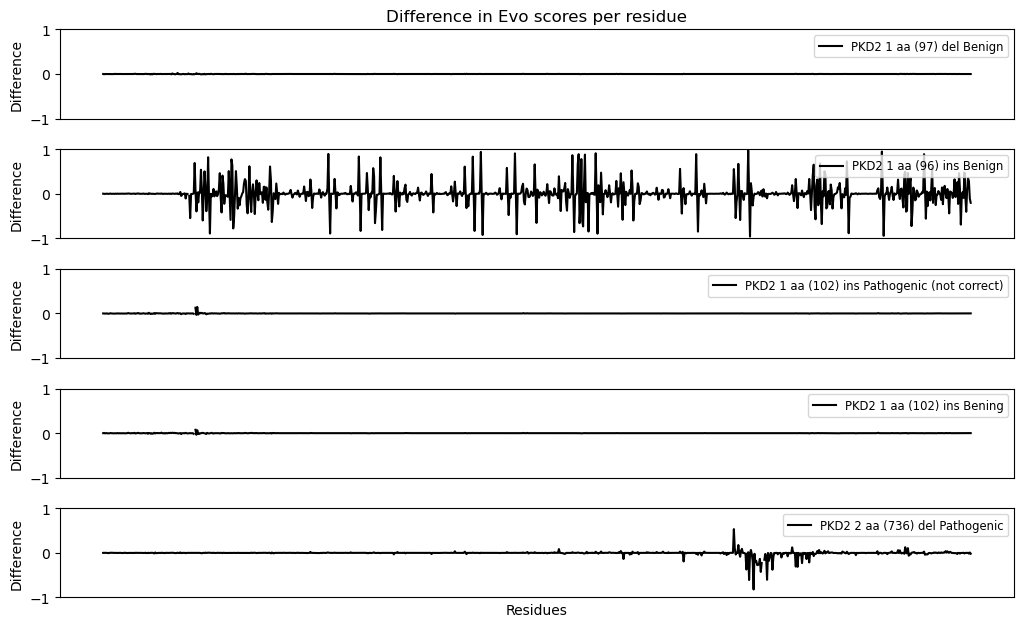

In [76]:
import matplotlib.pyplot as plt

#857
EvoscoresPKD2857_diff = []
for wt, mut in zip(EvoscoresPKD2857wt_row, EvoscoresPKD2857mut_row):
    if wt == '-' or mut == '-':
        EvoscoresPKD2857_diff.append('NaN')
    else:
        EvoscoresPKD2857_diff.append(mut - wt)

EvoscoresPKD2857_diff = pd.Series(EvoscoresPKD2857_diff)

#858
EvoscoresPKD2858_diff = []
for wt, mut in zip(EvoscoresPKD2858wt_row, EvoscoresPKD2858mut_row):
    if wt == '-' or mut == '-':
        EvoscoresPKD2858_diff.append('NaN')
    else:
        EvoscoresPKD2858_diff.append(mut - wt)

EvoscoresPKD2858_diff = pd.Series(EvoscoresPKD2858_diff)


#859
EvoscoresPKD2859_diff = []
for wt, mut in zip(EvoscoresPKD2859wt_row, EvoscoresPKD2859mut_row):
    if wt == '-' or mut == '-':
        EvoscoresPKD2859_diff.append('NaN')
    else:
        EvoscoresPKD2859_diff.append(mut - wt)

EvoscoresPKD2859_diff = pd.Series(EvoscoresPKD2859_diff)

#860
EvoscoresPKD2860_diff = []
for wt, mut in zip(EvoscoresPKD2860wt_row, EvoscoresPKD2860mut_row):
    if wt == '-' or mut == '-':
        EvoscoresPKD2860_diff.append('NaN')
    else:
        EvoscoresPKD2860_diff.append(mut - wt)

EvoscoresPKD2860_diff = pd.Series(EvoscoresPKD2860_diff)


#861
EvoscoresPKD2861_diff = []
for wt, mut in zip(EvoscoresPKD2861wt_row, EvoscoresPKD2861mut_row):
    if wt == '-' or mut == '-':
        EvoscoresPKD2861_diff.append('NaN')
    else:
        EvoscoresPKD2861_diff.append(mut - wt)

EvoscoresPKD2861_diff = pd.Series(EvoscoresPKD2861_diff)

f, axes = plt.subplots(5,1)
f.set_figheight(6)
f.set_figwidth(10)
f.tight_layout(pad=0.1)
axes[0].plot(EvoscoresPKD2857_diff.index, EvoscoresPKD2857_diff, color = "black", label = "PKD2 1 aa (97) del Benign")
axes[0].legend(fontsize='small')
axes[0].set_title('Difference in Evo scores per residue')
axes[1].plot(EvoscoresPKD2858_diff.index, EvoscoresPKD2858_diff, color = "black", label = "PKD2 1 aa (96) ins Benign")
axes[1].legend(fontsize='small')
axes[2].plot(EvoscoresPKD2859_diff.index, EvoscoresPKD2859_diff, color = "black", label = "PKD2 1 aa (102) ins Pathogenic (not correct)")
axes[2].legend(fontsize='small')
axes[3].plot(EvoscoresPKD2860_diff.index, EvoscoresPKD2860_diff, color = "black", label = "PKD2 1 aa (102) ins Bening")
axes[3].legend(fontsize='small')
axes[4].plot(EvoscoresPKD2861_diff.index, EvoscoresPKD2861_diff, color = "black", label = "PKD2 2 aa (736) del Pathogenic")
axes[4].legend(fontsize='small')
for ax in axes.flat:
    ax.set(xlabel = 'Residues', ylabel ='Difference')
    ax.set(ylim = (-1,1))
    ax.set(xticks = [])
for ax in axes.flat:
    ax.label_outer()

plt.show()

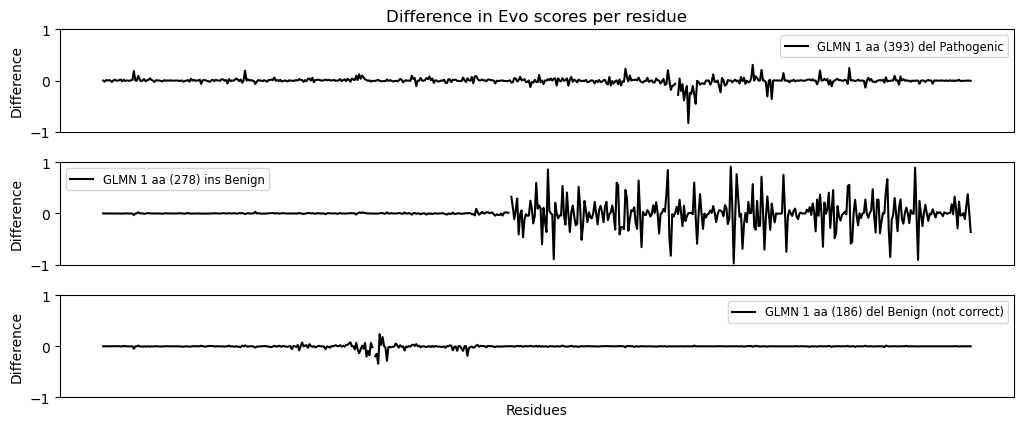

In [77]:
#128
EvoscoresGLMN128_diff = []
for wt, mut in zip(EvoscoresGLMN128wt_row, EvoscoresGLMN128mut_row):
    if wt == '-' or mut == '-':
        EvoscoresGLMN128_diff.append('NaN')
    else:
        EvoscoresGLMN128_diff.append(mut - wt)

EvoscoresGLMN128_diff = pd.Series(EvoscoresGLMN128_diff)

#129
EvoscoresGLMN129_diff = []
for wt, mut in zip(EvoscoresGLMN129wt_row, EvoscoresGLMN129mut_row):
    if wt == '-' or mut == '-':
        EvoscoresGLMN129_diff.append('NaN')
    else:
        EvoscoresGLMN129_diff.append(mut - wt)

EvoscoresGLMN129_diff = pd.Series(EvoscoresGLMN129_diff)

#130
EvoscoresGLMN130_diff = []
for wt, mut in zip(EvoscoresGLMN130wt_row, EvoscoresGLMN130mut_row):
    if wt == '-' or mut == '-':
        EvoscoresGLMN130_diff.append('NaN')
    else:
        EvoscoresGLMN130_diff.append(mut - wt)

EvoscoresGLMN130_diff = pd.Series(EvoscoresGLMN130_diff)

f, axes = plt.subplots(3,1)
f.set_figheight(4)
f.set_figwidth(10)
f.tight_layout(pad=0.1)
axes[0].plot(EvoscoresGLMN128_diff.index, EvoscoresGLMN128_diff, color = "black", label = "GLMN 1 aa (393) del Pathogenic")
axes[0].legend(fontsize='small')
axes[0].set_title('Difference in Evo scores per residue')
axes[1].plot(EvoscoresGLMN129_diff.index, EvoscoresGLMN129_diff, color = "black", label = "GLMN 1 aa (278) ins Benign")
axes[1].legend(fontsize='small')
axes[2].plot(EvoscoresGLMN130_diff.index, EvoscoresGLMN130_diff, color = "black", label = "GLMN 1 aa (186) del Benign (not correct)")
axes[2].legend(fontsize='small')
for ax in axes.flat:
    ax.set(xlabel = 'Residues', ylabel ='Difference')
    ax.set(ylim = (-1,1))
    ax.set(xticks = [])
for ax in axes.flat:
    ax.label_outer()

plt.show()

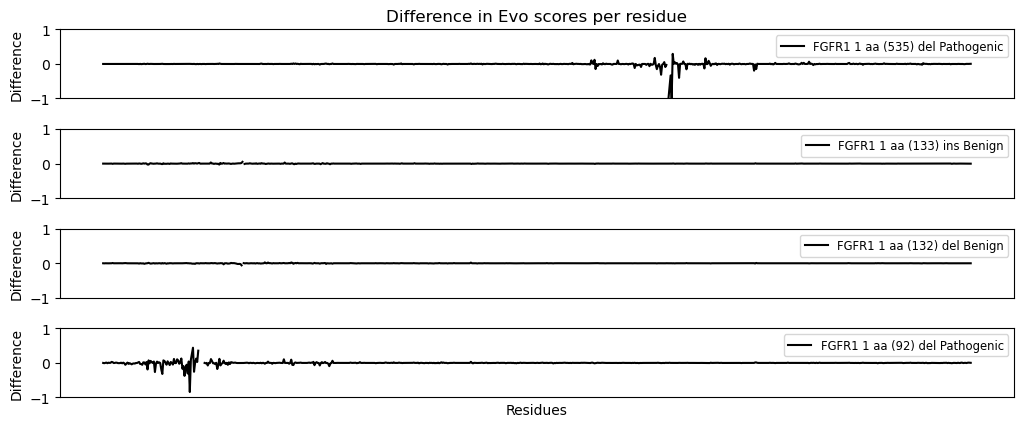

In [78]:
#1479
EvoscoresFGFR11479_diff = []
for wt, mut in zip(EvoscoresFGFR11479wt_row, EvoscoresFGFR11479mut_row):
    if wt == '-' or mut == '-':
        EvoscoresFGFR11479_diff.append('NaN')
    else:
        EvoscoresFGFR11479_diff.append(mut - wt)

EvoscoresFGFR11479_diff = pd.Series(EvoscoresFGFR11479_diff)

#1480
EvoscoresFGFR11480_diff = []
for wt, mut in zip(EvoscoresFGFR11480wt_row, EvoscoresFGFR11480mut_row):
    if wt == '-' or mut == '-':
        EvoscoresFGFR11480_diff.append('NaN')
    else:
        EvoscoresFGFR11480_diff.append(mut - wt)

EvoscoresFGFR11480_diff = pd.Series(EvoscoresFGFR11480_diff)

#1481
EvoscoresFGFR11481_diff = []
for wt, mut in zip(EvoscoresFGFR11481wt_row, EvoscoresFGFR11481mut_row):
    if wt == '-' or mut == '-':
        EvoscoresFGFR11481_diff.append('NaN')
    else:
        EvoscoresFGFR11481_diff.append(mut - wt)

EvoscoresFGFR11481_diff = pd.Series(EvoscoresFGFR11481_diff)

#1482
EvoscoresFGFR11482_diff = []
for wt, mut in zip(EvoscoresFGFR11482wt_row, EvoscoresFGFR11482mut_row):
    if wt == '-' or mut == '-':
        EvoscoresFGFR11482_diff.append('NaN')
    else:
        EvoscoresFGFR11482_diff.append(mut - wt)

EvoscoresFGFR11482_diff = pd.Series(EvoscoresFGFR11482_diff)

f, axes = plt.subplots(4,1)
f.set_figheight(4)
f.set_figwidth(10)
f.tight_layout(pad=0.1)
axes[0].plot(EvoscoresFGFR11479_diff.index, EvoscoresFGFR11479_diff, color = "black", label = "FGFR1 1 aa (535) del Pathogenic")
axes[0].legend(fontsize='small')
axes[0].set_title('Difference in Evo scores per residue')
axes[1].plot(EvoscoresFGFR11480_diff.index, EvoscoresFGFR11480_diff, color = "black", label = "FGFR1 1 aa (133) ins Benign")
axes[1].legend(fontsize='small')
axes[2].plot(EvoscoresFGFR11481_diff.index, EvoscoresFGFR11481_diff, color = "black", label = "FGFR1 1 aa (132) del Benign")
axes[2].legend(fontsize='small')
axes[3].plot(EvoscoresFGFR11482_diff.index, EvoscoresFGFR11482_diff, color = "black", label = "FGFR1 1 aa (92) del Pathogenic")
axes[3].legend(fontsize='small')
for ax in axes.flat:
    ax.set(xlabel = 'Residues', ylabel ='Difference')
    ax.set(ylim = (-1,1))
    ax.set(xticks = [])
for ax in axes.flat:
    ax.label_outer()

plt.show()